In [1]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import cmasher as cm
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')
import jax
from scipy import stats
import matplotlib.gridspec as grid
from matplotlib.colors import LogNorm

In [2]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data = tb[1].data 

In [3]:
# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_catalogo_14_mayo.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb2 = fits.open(path+file)
data2 = tb2[1].data
gc_star_ids = data2.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids))+' GC stars')

# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'VAC_GC_DR17_synspec_rev1_beta.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb3 = fits.open(path+file)
data3 = tb3[1].data
gc_star_ids_RPS = data3.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids_RPS))+' GC stars')

There are 7562 GC stars
There are 7737 GC stars


In [4]:
apo_id = data['APOGEE_ID']
# Clean the initial data
mask_gcs = np.isin(list(apo_id),list(gc_star_ids))
mask_gcs2 = np.isin(list(apo_id),list(gc_star_ids_RPS))

In [5]:
starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()

aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

536568

In [6]:
# create the parent mask
mask = (data['SNR']>50)&(data['LOGG']<3.5)&(data['LOGG']>1.)&(data['TEFF']>3500.)&(data['TEFF']<5500.)\
    &(mask_gcs==False)&(mask_gcs2==False)&(starflag_mask)&(aspcapflag_mask)&(data['ruwe']<1.4)&\
    (data['parallax']>0.2)&(data['parallax_over_error']>8.)

print('There are '+str(len(data[mask]))+' stars in the parent sample')


There are 174274 stars in the parent sample


In [7]:
import galpy
from galpy.util import coords
from galpy.potential import IsochronePotential
from galpy.actionAngle import actionAngleIsochrone
# from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import estimateDeltaStaeckel
from astropy.io import fits
import tqdm
from galpy.orbit import Orbit
from galpy.potential.mwpotentials import McMillan17
from galpy.util.conversion import get_physical
from galpy.actionAngle import UnboundError


A new version of galpy (1.9.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [8]:
def dat_to_galcen(dat,
                  return_rphiz =True,
                  verbose =False,
                  ro = 8.275,  # GRAVITY 2018 value 
                  vo = 220.,   # GRAVITY 2018 value 
                  zo = 0.02,    # Bennet and Bovy 2018 value
                  keys = ['RA', 'DEC', 'GAIAEDR3_R_MED_PHOTOGEO', 'pmra', 'pmdec', 'VHELIO_AVG'],
                  #cov_keys = [dat['pmra_error_1'],dat['pmdec_error_1'],dat['SH_weighted_diststd'],dat['VERR_1']],
                  parallax = False):
    vxvv = np.dstack([dat[keys[i]] for i in range(len(keys))])[0]
    ra, dec= vxvv[:,0], vxvv[:,1]
    lb= coords.radec_to_lb(ra,dec,degree=True, epoch=None)
    pmra, pmdec= vxvv[:,3], vxvv[:,4]
    pmllpmbb= coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
    d, vlos= vxvv[:,2]/1e3, vxvv[:,5]
    if parallax:
        d = 1./d
    rectgal= coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)
    vsolar= np.array([-8.4,31.8,8.4]) # Values from Ted's halo paper, taken from Schrondich 2010 and adjusted given by the proper motion values for SGR A* by the GRAVITY collaboration. Vx is negative because we adopt the x convention to go in opposite direction
    vsun= np.array([0.,1.,0.,])+vsolar/vo
    X = rectgal[:,0]/ro
    Y = rectgal[:,1]/ro
    Z = rectgal[:,2]/ro
    vx = rectgal[:,3]/vo
    vy = rectgal[:,4]/vo
    vz = rectgal[:,5]/vo
    XYZ = np.dstack([X, Y, Z])[0]
    vxyz = np.dstack([vx,vy,vz])[0]
    Rpz = coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],Zsun=zo/ro)
    vRvTvz = coords.vxvyvz_to_galcencyl(vxyz[:,0], vxyz[:,1], vxyz[:,2], Rpz[:,0], Rpz[:,1], Rpz[:,2],
                                                                    vsun=vsun,
                                                                    Xsun=1.,
                                                                    Zsun=zo/ro,
                                                                    galcen=True)
    return XYZ, vxyz, Rpz, vRvTvz


In [9]:
xyz,vxyz,Rpz,vRvTvz = dat_to_galcen(data)

# Plot the kinematic and action 3 panel OTI 

In [10]:
# Eilers rotation curve
R = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(R-8.275)
Rg = (-data['L'][:,2]/vcirc)
phi = np.arctan(data['xyz'][:,1]/-data['xyz'][:,0])
phi_x1 = R*np.cos(phi)
phi_y1 = R*np.sin(phi)
vr = vRvTvz[:,0]*220.
print(R)
deltaR = R-Rg


[ 9.87188323  8.63580707 22.58525074 ...  5.15168728  5.15372958
  5.80486113]


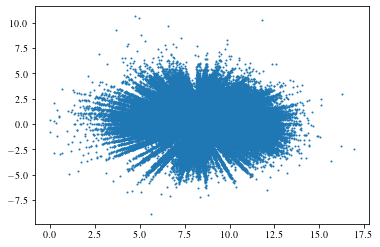

In [73]:
plt.scatter(phi_x1[mask],phi_y1[mask],s=1)

In [11]:
z_x2 = np.sqrt(data['actions'][:,2])*np.cos(data['angles'][:,2])
z_y2 = np.sqrt(data['actions'][:,2])*np.sin(data['angles'][:,2])
R_x2 = np.sqrt(data['actions'][:,0])*np.cos(data['angles'][:,0])
R_y2 = np.sqrt(data['actions'][:,0])*np.sin(data['angles'][:,0])
phi_x2 = -np.sqrt(-data['L'][:,2])*np.cos(data['angles'][:,1])
phi_y2 = -np.sqrt(-data['L'][:,2])*np.sin(data['angles'][:,1])


(-20.0, 20.0)

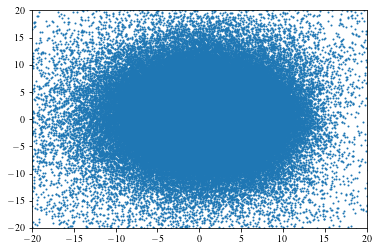

In [12]:
plt.scatter(R_x[mask],R_y[mask],s=1)
plt.xlim(-20,20)
plt.ylim(-20,20)

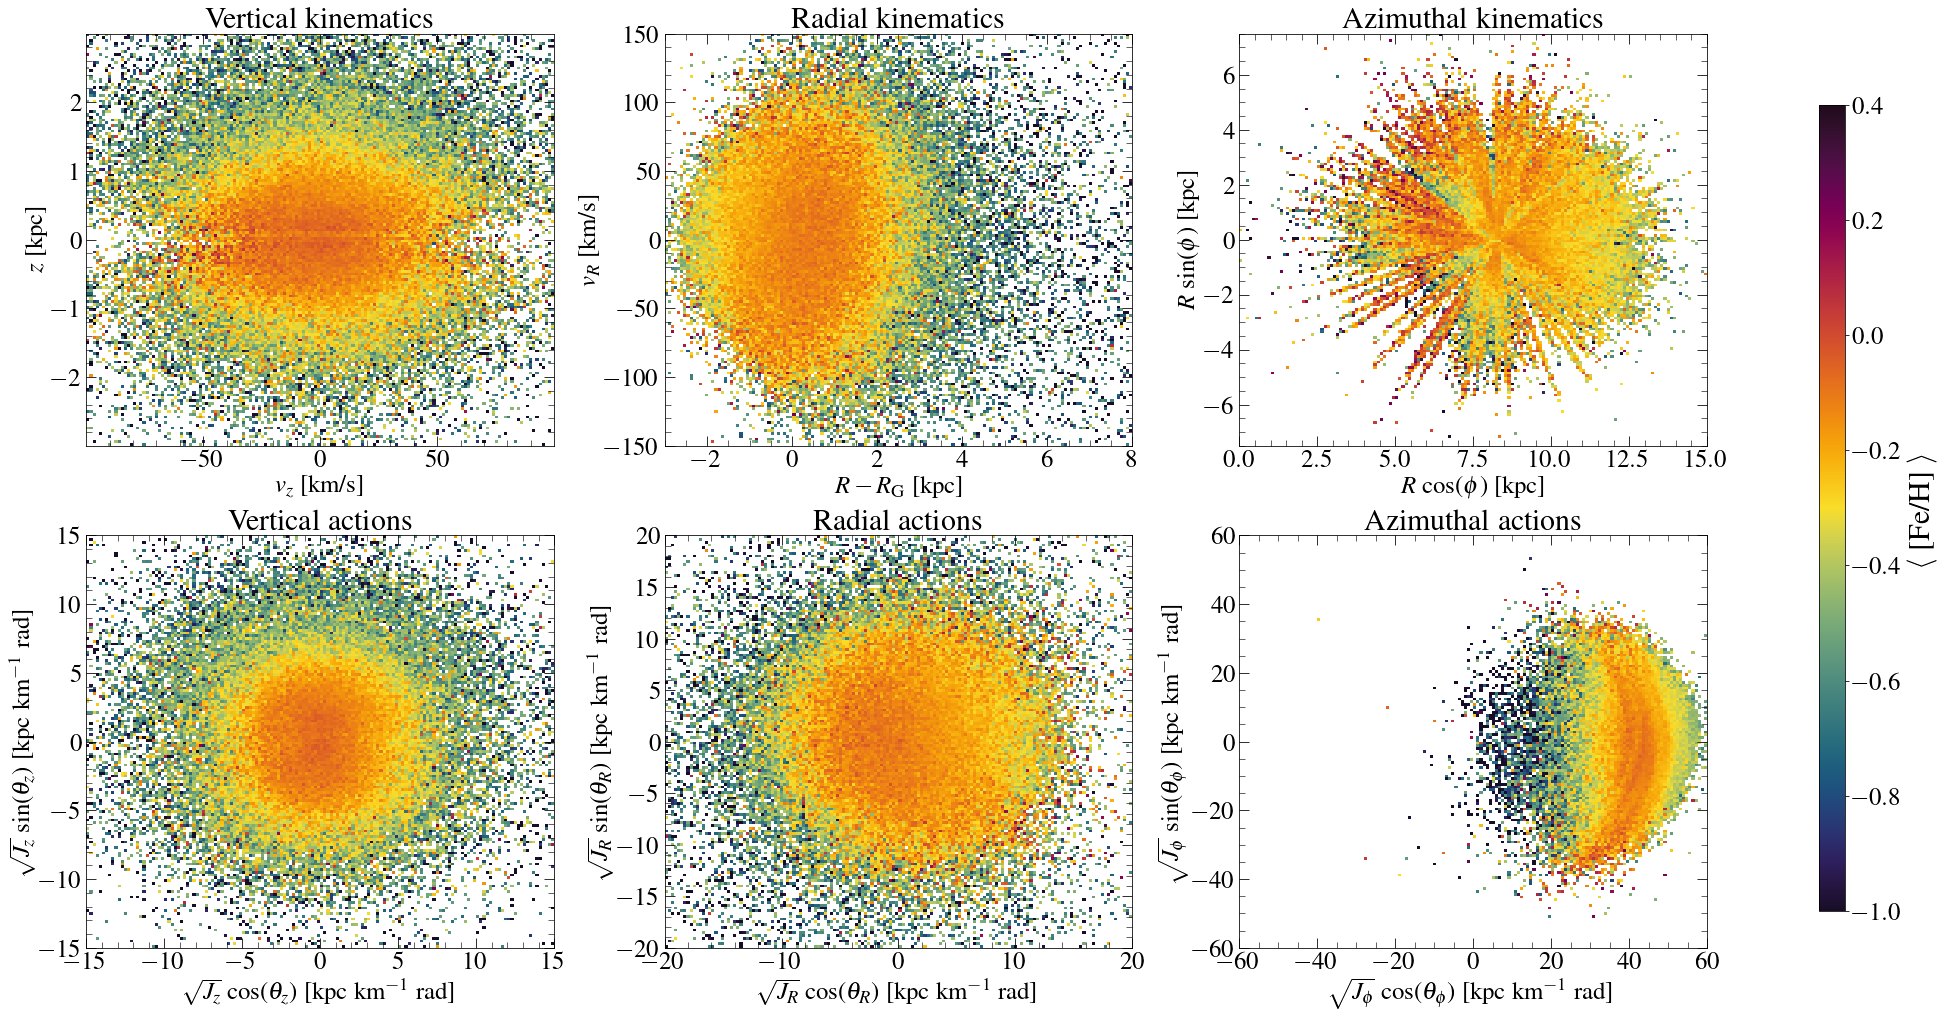

In [14]:
from scipy import stats
nbins=151
stat='mean'
fig = plt.figure(figsize=(24,14),constrained_layout=True,facecolor='white', rasterized=True)

plt.subplot(2,3,1)
mask_kinematics = (np.abs(data['vxyz'][:,2])<100)&(np.abs(data['xyz'][:,2])<3)&(np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<1)
abun = data['FE_H']
binx = np.linspace(np.min(data['vxyz'][:,2][mask&mask_kinematics]),np.max(data['vxyz'][:,2][mask&mask_kinematics]),nbins)
biny = np.linspace(np.min(data['xyz'][:,2][mask&mask_kinematics]),np.max(data['xyz'][:,2][mask&mask_kinematics]),nbins)    
hist = stats.binned_statistic_2d(data['vxyz'][:,2][mask&mask_kinematics],data['xyz'][:,2][mask&mask_kinematics], abun[mask&mask_kinematics], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.title('Vertical kinematics',fontsize=30)
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.pride,vmin=-1.,vmax=0.4)
plt.ylabel('$z$ [kpc]', fontsize=25)
plt.xlabel('$v_z$ [km/s]', fontsize=25)
# plt.xlim(-80,80)
# plt.ylim(-4,4)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()


plt.subplot(2,3,2)
mask_kinematics = (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<1)
abun = data['FE_H']
binx = np.linspace(-3,8,nbins)
biny = np.linspace(-150,150,nbins)    
hist = stats.binned_statistic_2d(deltaR[mask&mask_kinematics],vr[mask&mask_kinematics], abun[mask&mask_kinematics], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.title('Radial kinematics',fontsize=30)
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.pride,vmin=-1.,vmax=0.4)
plt.xlabel('$R - R_{\mathrm{G}}$ [kpc]', fontsize=25)
plt.ylabel('$v_R$ [km/s]', fontsize=25)
# plt.xlim(-2,6)
# plt.ylim(-150,150)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

# cbar_ax = fig.add_axes([1.05, 0.1, 0.015,0.8])
# cb = plt.colorbar(cax = cbar_ax,orientation='vertical')
# cb.set_label(label=r'$\langle$Age [Gyr] $\rangle$',fontsize=30)
# cb.ax.tick_params(labelsize=25)
# cb.ax.xaxis.set_ticks_position('top')
# cb.ax.xaxis.set_label_position('top')


plt.subplot(2,3,3)
mask_kinematics = (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<1)
abun = data['FE_H']
binx = np.linspace(0,15,nbins)
biny = np.linspace(-7.5,7.5,nbins) 
hist = stats.binned_statistic_2d(phi_x1[mask&mask_kinematics],phi_y1[mask&mask_kinematics], abun[mask&mask_kinematics], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.title('Azimuthal kinematics',fontsize=30)
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.pride,vmin=-1.,vmax=0.4)
plt.xlabel(r'$R$ cos($\phi$) [kpc]', fontsize=25)
plt.ylabel(r'$R$ sin($\phi$) [kpc]', fontsize=25)
# plt.xlim(25,55)
# plt.ylim(-30,30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

# cbar_ax = fig.add_axes([1.05, 0.1, 0.015,0.8])
# cb = plt.colorbar(cax = cbar_ax,orientation='vertical')
# cb.set_label(label=r'$\langle$ [Fe/H] $\rangle$',fontsize=30)
# cb.ax.tick_params(labelsize=25)
# cb.ax.xaxis.set_ticks_position('top')
# cb.ax.xaxis.set_label_position('top')





plt.subplot(2,3,4)
mask_kinematics = (np.abs(z_x)<30)&(np.abs(z_y)<30)&(np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<1)
abun = data['FE_H']
binx = np.linspace(-15,15,nbins)
biny = np.linspace(-15,15,nbins)    
hist = stats.binned_statistic_2d(z_x[mask&mask_kinematics],z_y[mask&mask_kinematics], abun[mask&mask_kinematics], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.title('Vertical actions',fontsize=30)
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.pride,vmin=-1.,vmax=0.4)
plt.xlabel(r'$\sqrt{J_{z}}$ cos($\theta_{z}$) [kpc km$^{-1}$ rad]', fontsize=25)
plt.ylabel(r'$\sqrt{J_{z}}$ sin($\theta_{z}$) [kpc km$^{-1}$ rad]', fontsize=25)
# plt.xlim(-80,80)
# plt.ylim(-4,4)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()


plt.subplot(2,3,5)
mask_kinematics = (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<1)
abun = data['FE_H']
binx = np.linspace(-20,20,nbins)
biny = np.linspace(-20,20,nbins)    
hist = stats.binned_statistic_2d(R_x[mask&mask_kinematics],R_y[mask&mask_kinematics], abun[mask&mask_kinematics], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.title('Radial actions',fontsize=30)
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.pride,vmin=-1.,vmax=0.4)
plt.xlabel(r'$\sqrt{J_{R}}$ cos($\theta_{R}$) [kpc km$^{-1}$ rad]', fontsize=25)
plt.ylabel(r'$\sqrt{J_{R}}$ sin($\theta_{R}$) [kpc km$^{-1}$ rad]', fontsize=25)
# plt.xlim(-2,6)
# plt.ylim(-150,150)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

# # cbar_ax = fig.add_axes([1.05, 0.1, 0.015,0.8])
# # cb = plt.colorbar(cax = cbar_ax,orientation='vertical')
# # cb.set_label(label=r'$\langle$Age [Gyr] $\rangle$',fontsize=30)
# # cb.ax.tick_params(labelsize=25)
# # cb.ax.xaxis.set_ticks_position('top')
# # cb.ax.xaxis.set_label_position('top')


plt.subplot(2,3,6)
mask_kinematics = (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<1)
abun = data['FE_H']
binx = np.linspace(-60,60,nbins)
biny = np.linspace(-60,60,nbins) 
hist = stats.binned_statistic_2d(phi_x2[mask&mask_kinematics],phi_y2[mask&mask_kinematics], abun[mask&mask_kinematics], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.title('Azimuthal actions',fontsize=30)
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.pride,vmin=-1.,vmax=0.4)
plt.xlabel(r'$\sqrt{J_{\phi}}$ cos($\theta_{\phi}$) [kpc km$^{-1}$ rad]', fontsize=25)
plt.ylabel(r'$\sqrt{J_{\phi}}$ sin($\theta_{\phi}$) [kpc km$^{-1}$ rad]', fontsize=25)
# plt.xlim(25,55)
# plt.ylim(-30,30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([1.05, 0.1, 0.015,0.8])
cb = plt.colorbar(cax = cbar_ax,orientation='vertical')
cb.set_label(label=r'$\langle$ [Fe/H] $\rangle$',fontsize=30)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/kinematics-orbits-oti-feh.pdf',dpi=200, bbox_inches = 'tight')



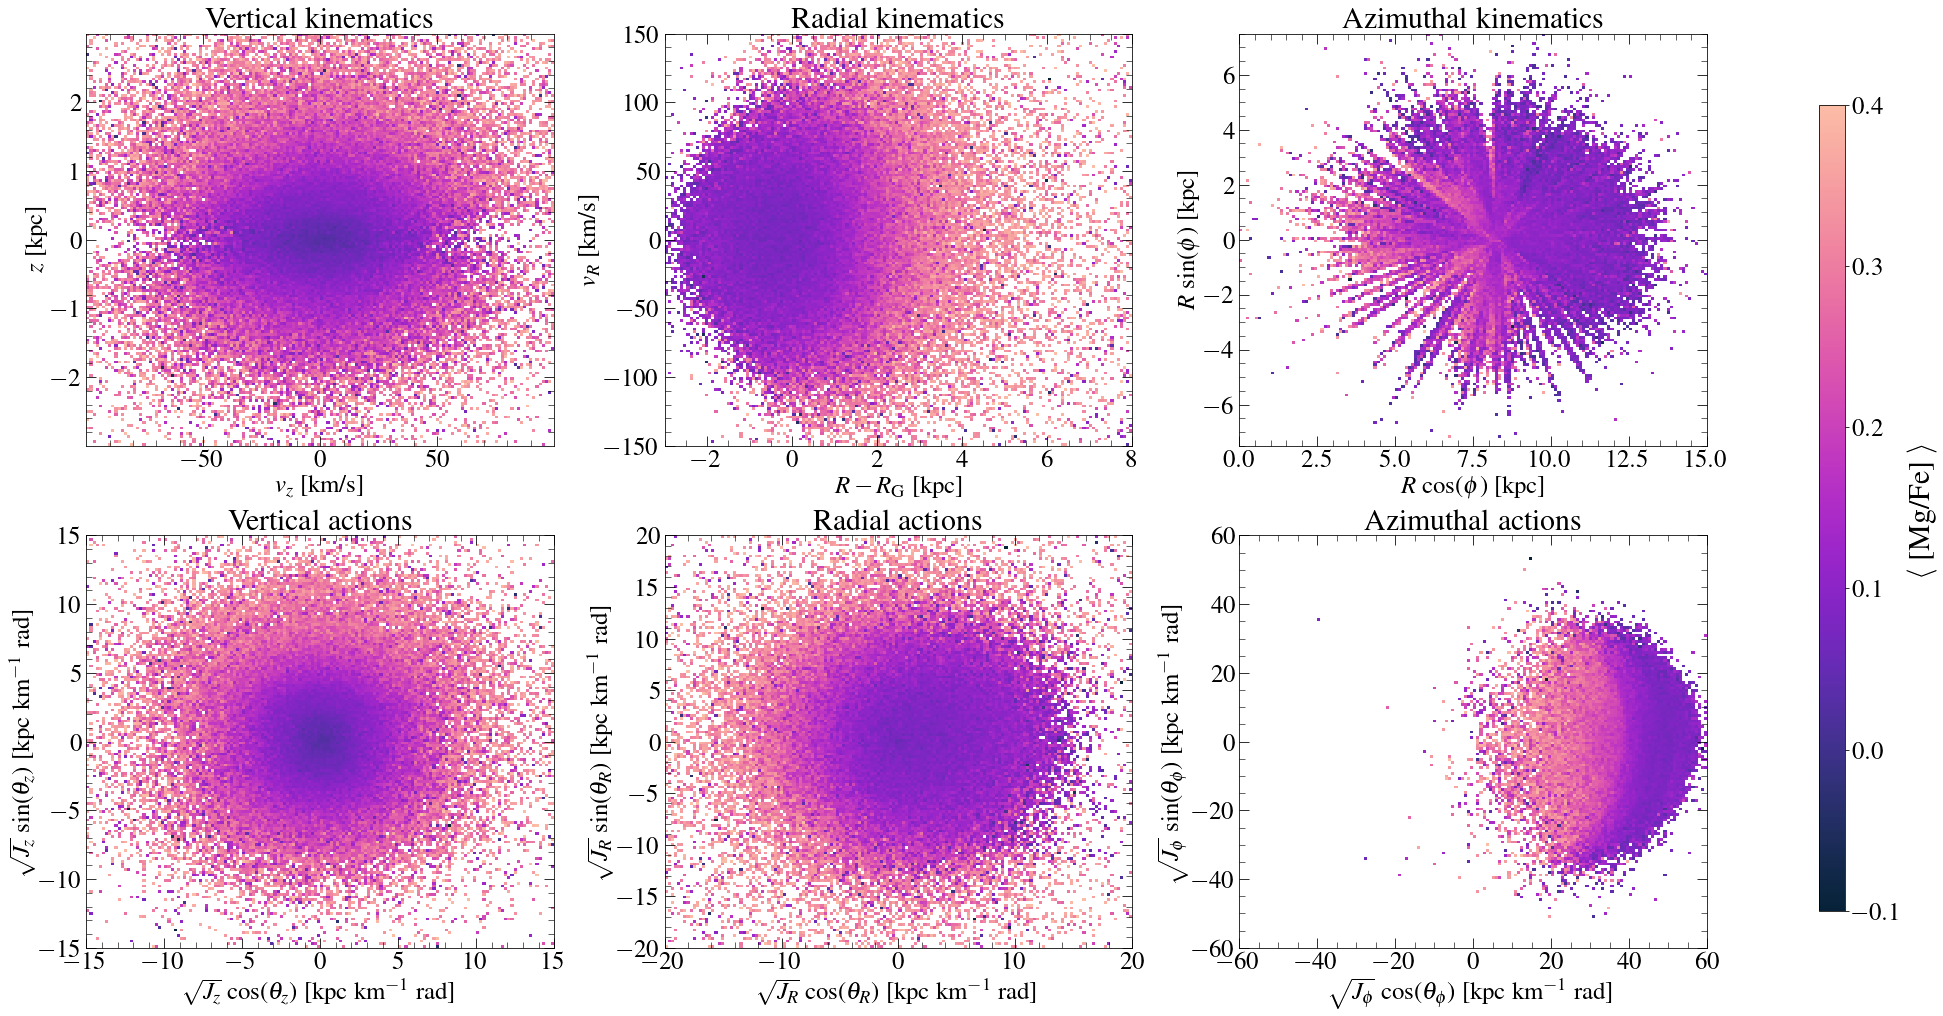

In [15]:
from scipy import stats
nbins=151
stat='mean'
fig = plt.figure(figsize=(24,14),constrained_layout=True,facecolor='white',rasterized=True)

plt.subplot(2,3,1)
mask_kinematics = (np.abs(data['vxyz'][:,2])<100)&(np.abs(data['xyz'][:,2])<3)&(np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<1)
abun = data['MG_FE']
binx = np.linspace(np.min(data['vxyz'][:,2][mask&mask_kinematics]),np.max(data['vxyz'][:,2][mask&mask_kinematics]),nbins)
biny = np.linspace(np.min(data['xyz'][:,2][mask&mask_kinematics]),np.max(data['xyz'][:,2][mask&mask_kinematics]),nbins)    
hist = stats.binned_statistic_2d(data['vxyz'][:,2][mask&mask_kinematics],data['xyz'][:,2][mask&mask_kinematics], abun[mask&mask_kinematics], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.title('Vertical kinematics',fontsize=30)
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.bubblegum,vmin=-0.1,vmax=0.4)
plt.ylabel('$z$ [kpc]', fontsize=25)
plt.xlabel('$v_z$ [km/s]', fontsize=25)
# plt.xlim(-80,80)
# plt.ylim(-4,4)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()


plt.subplot(2,3,2)
mask_kinematics = (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<1)
abun = data['MG_FE']
binx = np.linspace(-3,8,nbins)
biny = np.linspace(-150,150,nbins)    
hist = stats.binned_statistic_2d(deltaR[mask&mask_kinematics],vr[mask&mask_kinematics], abun[mask&mask_kinematics], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.title('Radial kinematics',fontsize=30)
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.bubblegum,vmin=-0.1,vmax=0.4)
plt.xlabel('$R - R_{\mathrm{G}}$ [kpc]', fontsize=25)
plt.ylabel('$v_R$ [km/s]', fontsize=25)
# plt.xlim(-2,6)
# plt.ylim(-150,150)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

# cbar_ax = fig.add_axes([1.05, 0.1, 0.015,0.8])
# cb = plt.colorbar(cax = cbar_ax,orientation='vertical')
# cb.set_label(label=r'$\langle$Age [Gyr] $\rangle$',fontsize=30)
# cb.ax.tick_params(labelsize=25)
# cb.ax.xaxis.set_ticks_position('top')
# cb.ax.xaxis.set_label_position('top')


plt.subplot(2,3,3)
mask_kinematics = (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<1)
abun = data['MG_FE']
binx = np.linspace(0,15,nbins)
biny = np.linspace(-7.5,7.5,nbins) 
hist = stats.binned_statistic_2d(phi_x1[mask&mask_kinematics],phi_y1[mask&mask_kinematics], abun[mask&mask_kinematics], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.title('Azimuthal kinematics',fontsize=30)
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.bubblegum,vmin=-0.1,vmax=0.4)
plt.xlabel(r'$R$ cos($\phi$) [kpc]', fontsize=25)
plt.ylabel(r'$R$ sin($\phi$) [kpc]', fontsize=25)
# plt.xlim(25,55)
# plt.ylim(-30,30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

# cbar_ax = fig.add_axes([1.05, 0.1, 0.015,0.8])
# cb = plt.colorbar(cax = cbar_ax,orientation='vertical')
# cb.set_label(label=r'$\langle$ [Fe/H] $\rangle$',fontsize=30)
# cb.ax.tick_params(labelsize=25)
# cb.ax.xaxis.set_ticks_position('top')
# cb.ax.xaxis.set_label_position('top')





plt.subplot(2,3,4)
mask_kinematics = (np.abs(z_x)<30)&(np.abs(z_y)<30)&(np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<1)
abun = data['MG_FE']
binx = np.linspace(-15,15,nbins)
biny = np.linspace(-15,15,nbins)    
hist = stats.binned_statistic_2d(z_x[mask&mask_kinematics],z_y[mask&mask_kinematics], abun[mask&mask_kinematics], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.title('Vertical actions',fontsize=30)
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.bubblegum,vmin=-0.1,vmax=0.4)
plt.xlabel(r'$\sqrt{J_{z}}$ cos($\theta_{z}$) [kpc km$^{-1}$ rad]', fontsize=25)
plt.ylabel(r'$\sqrt{J_{z}}$ sin($\theta_{z}$) [kpc km$^{-1}$ rad]', fontsize=25)
# plt.xlim(-80,80)
# plt.ylim(-4,4)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()


plt.subplot(2,3,5)
mask_kinematics = (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<1)
abun = data['MG_FE']
binx = np.linspace(-20,20,nbins)
biny = np.linspace(-20,20,nbins)    
hist = stats.binned_statistic_2d(R_x[mask&mask_kinematics],R_y[mask&mask_kinematics], abun[mask&mask_kinematics], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.title('Radial actions',fontsize=30)
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.bubblegum,vmin=-0.1,vmax=0.4)
plt.xlabel(r'$\sqrt{J_{R}}$ cos($\theta_{R}$) [kpc km$^{-1}$ rad]', fontsize=25)
plt.ylabel(r'$\sqrt{J_{R}}$ sin($\theta_{R}$) [kpc km$^{-1}$ rad]', fontsize=25)
# plt.xlim(-2,6)
# plt.ylim(-150,150)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

# # cbar_ax = fig.add_axes([1.05, 0.1, 0.015,0.8])
# # cb = plt.colorbar(cax = cbar_ax,orientation='vertical')
# # cb.set_label(label=r'$\langle$Age [Gyr] $\rangle$',fontsize=30)
# # cb.ax.tick_params(labelsize=25)
# # cb.ax.xaxis.set_ticks_position('top')
# # cb.ax.xaxis.set_label_position('top')


plt.subplot(2,3,6)
mask_kinematics = (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<1)
abun = data['MG_FE']
binx = np.linspace(-60,60,nbins)
biny = np.linspace(-60,60,nbins) 
hist = stats.binned_statistic_2d(phi_x2[mask&mask_kinematics],phi_y2[mask&mask_kinematics], abun[mask&mask_kinematics], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.title('Azimuthal actions',fontsize=30)
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.bubblegum,vmin=-0.1,vmax=0.4)
plt.xlabel(r'$\sqrt{J_{\phi}}$ cos($\theta_{\phi}$) [kpc km$^{-1}$ rad]', fontsize=25)
plt.ylabel(r'$\sqrt{J_{\phi}}$ sin($\theta_{\phi}$) [kpc km$^{-1}$ rad]', fontsize=25)
# plt.xlim(25,55)
# plt.ylim(-30,30)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([1.05, 0.1, 0.015,0.8])
cb = plt.colorbar(cax = cbar_ax,orientation='vertical')
cb.set_label(label=r'$\langle$ [Mg/Fe] $\rangle$',fontsize=30)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/kinematics-orbits-oti-mgfe.pdf',dpi=200, bbox_inches = 'tight')



In [62]:
line = data['FE_H']*-0.167 + 0.12

lowa_disc_mask = ((data['FE_H']>-0.8)&(data['FE_H']<-0.4)&(data['MG_FE']<0.185))|((data['FE_H']>-0.4)&(data['FE_H']<-0.05)&(data['MG_FE']<line))|((data['FE_H']>-0.05)&(data['FE_H']<0.6)&(data['MG_FE']<0.12))


higha_disc_mask_strict = ((data['FE_H']>-1)&(data['FE_H']<-0.4)&(data['MG_FE']>line))|\
((data['FE_H']>-0.4)&(data['FE_H']<0.6)&(data['MG_FE']>0.185))

higha_disc_mask = ((data['FE_H']>-1)&(data['FE_H']<0.)&(data['MG_FE']>line))|((data['FE_H']>0.)&(data['FE_H']<0.6)&(data['MG_FE']>0.12))


inta_disc_mask = ((data['FE_H']>-0.4)&(data['FE_H']<-0.0)&(data['MG_FE']>line)&(data['MG_FE']<0.22))|((data['FE_H']>0.0)&(data['FE_H']<0.6)&(data['MG_FE']>0.12)&(data['MG_FE']<0.22))

other_mask = (~higha_disc_mask)&(~lowa_disc_mask)&(data['FE_H']<-0.6)

print(len(data[mask&lowa_disc_mask]))
print(len(data[mask&higha_disc_mask]))
print(len(data[mask&other_mask]))


121413
49362
3072


# Now loop over one variable and plot the other two

In [60]:
def plot_3_3(var1, var2, var3, abun, mask1, mask2, mask3,n=5,nbins=91,xfe_label=r'$\langle$[Mg/Fe]$\rangle$',\
            label1=r'$\Delta R$ [kpc]', label2 = r'$R_{g}$ [kpc]', label3=r'$z_{\mathrm{max}}$ [kpc]',\
            xlim1 = 0, xlim2 = 15, ylim1 =0, ylim2 = 8,xnstar = 9, ynstar = 7):
    """
    Take three variables (say J) and 3 samples (say high-/low-alpha discs and halo) and plot two variables conditioned
    on the other. 
    """
    
    fig, all_axes = plt.subplots(3, 4, constrained_layout=True, figsize=(30, 18), sharex=True, sharey=True, rasterized=True)
    
    # for mask1
    xs = np.around(np.linspace(np.min(var1[mask1]),np.max(var1[mask1]),n),decimals=2)
    # for mask2
    xs2 = np.around(np.linspace(np.min(var1[mask2]),np.max(var1[mask2]),n),decimals=2)
    # for mask3
    xs3 = np.around(np.linspace(np.min(var1[mask3]),np.max(var1[mask3]),n),decimals=2)   
    
    # set up an array of the x grids to loop over
    exis = np.array((xs,xs2,xs3))
    
    for indx, i in enumerate(exis):
        axis = all_axes[indx]
        for indx2, k in enumerate(i[:-1]):
                # create a mask for every loop
                if k<i[-1] and indx==0:
                        mask_loop = (var1[mask1]>k)&(var1[mask1]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask1]),np.max(var2[mask1]),nbins)
                        biny = np.linspace(np.min(var3[mask1]),np.max(var3[mask1]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask1][mask_loop],var3[mask1][mask_loop], abun[mask1][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.0,vmax=0.1)         
                        ax.set_xlim(xlim1,xlim2)
                        ax.set_ylim(ylim1,ylim2)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(xnstar,ynstar,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask1][mask_loop])),fontsize=25)
                        ax.set_title(r'' +str('%5.2f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.2f' %i[indx2+1]),fontsize=30)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()
                        
                if k<i[-1] and indx==1:
                        mask_loop = (var1[mask2]>k)&(var1[mask2]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask2]),np.max(var2[mask2]),nbins)
                        biny = np.linspace(np.min(var3[mask2]),np.max(var3[mask2]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask2][mask_loop],var3[mask2][mask_loop], abun[mask2][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=0.15,vmax=0.3)         
                        ax.set_xlim(xlim1,xlim2)
                        ax.set_ylim(ylim1,ylim2)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(xnstar,ynstar,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask2][mask_loop])),fontsize=25)
                        ax.set_title(r'' +str('%5.2f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.2f' %i[indx2+1]),fontsize=30)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()

                if k<i[-1] and indx==2:
                        mask_loop = (var1[mask3]>k)&(var1[mask3]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask3]),np.max(var2[mask3]),nbins)
                        biny = np.linspace(np.min(var3[mask3]),np.max(var3[mask3]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask3][mask_loop],var3[mask3][mask_loop], abun[mask3][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.1,vmax=0.3)         
                        ax.set_xlim(xlim1,xlim2)
                        ax.set_ylim(ylim1,ylim2)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(xnstar,ynstar,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask3][mask_loop])),fontsize=25)
                        ax.set_title(r'' +str('%5.2f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.2f' %i[indx2+1]),fontsize=30)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()
                else:
                    pass
        cbar = fig.colorbar(color, ax = axis, aspect=15)
        cbar.set_label(label=xfe_label,fontsize=25)
        cbar.ax.tick_params(labelsize=25)

    for ax in all_axes[-1]:
        ax.set_xlabel(label2,fontsize=40)

    all_axes[0,0].set_ylabel(r'Low-$\alpha$ disc' +' \n '+str(label3),fontsize=40,labelpad=15)
    all_axes[1,0].set_ylabel(r'High-$\alpha$ disc' +' \n '+str(label3),fontsize=40,labelpad=15)
    all_axes[2,0].set_ylabel(r'Halo' +' \n '+str(label3),fontsize=40,labelpad=15)
  

# vertical space as a function of $R$ and $\phi$

In [63]:
z = data['xyz'][:,2]
vz = data['vxyz'][:,2]

lowa =mask&lowa_disc_mask&(Rg>2)&(Rg<14) &(np.abs(z)<5)&(np.abs(vz)<120)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z))
higha = mask&higha_disc_mask&(Rg>2)&(Rg<14)&(np.abs(z)<5)&(np.abs(vz)<120)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z))
halo = mask&other_mask&(Rg>2)&(Rg<14)&(np.abs(z)<5)&(np.abs(vz)<120)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z))


In [57]:
print(len(data[halo]))

1824


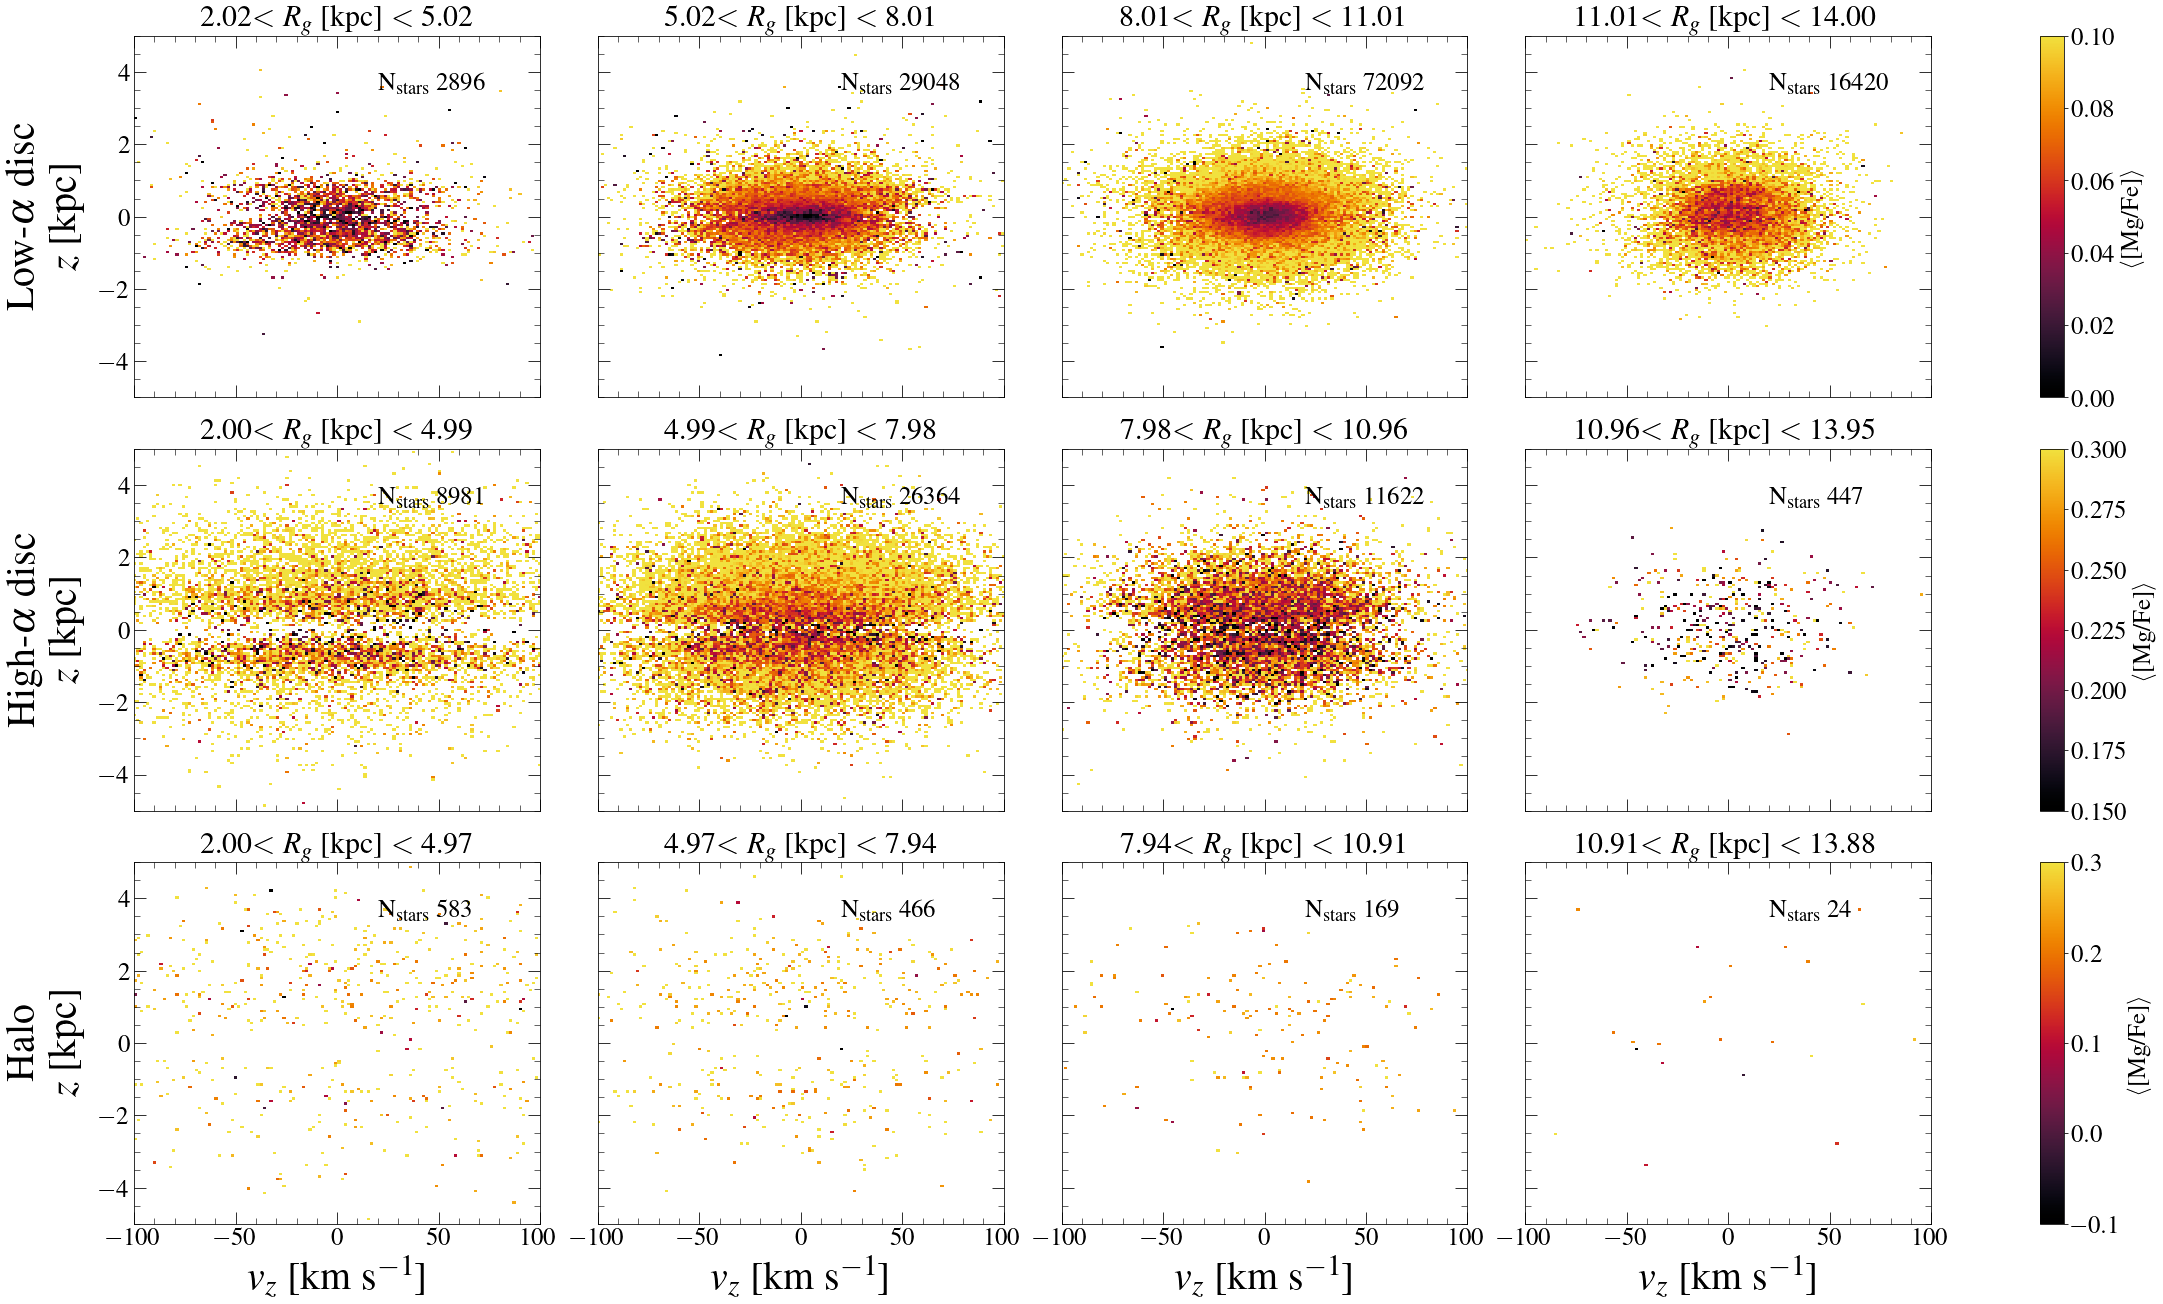

In [65]:
plot_3_3(Rg,vz,z, data['MG_FE'],lowa,higha,halo,label1=r'$R_g$ [kpc]',\
         label2 = r'$v_{z}$ [km s$^{-1}$]', label3=r'$z$ [kpc]',\
            xlim1 = -100, xlim2 = 100, ylim1 =-5, ylim2 = 5,xnstar = 20, ynstar = 3.5,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/zvz-Rg-3x3.pdf',dpi=200, bbox_inches = 'tight')


In [66]:
phi_rad = phi*180./np.pi

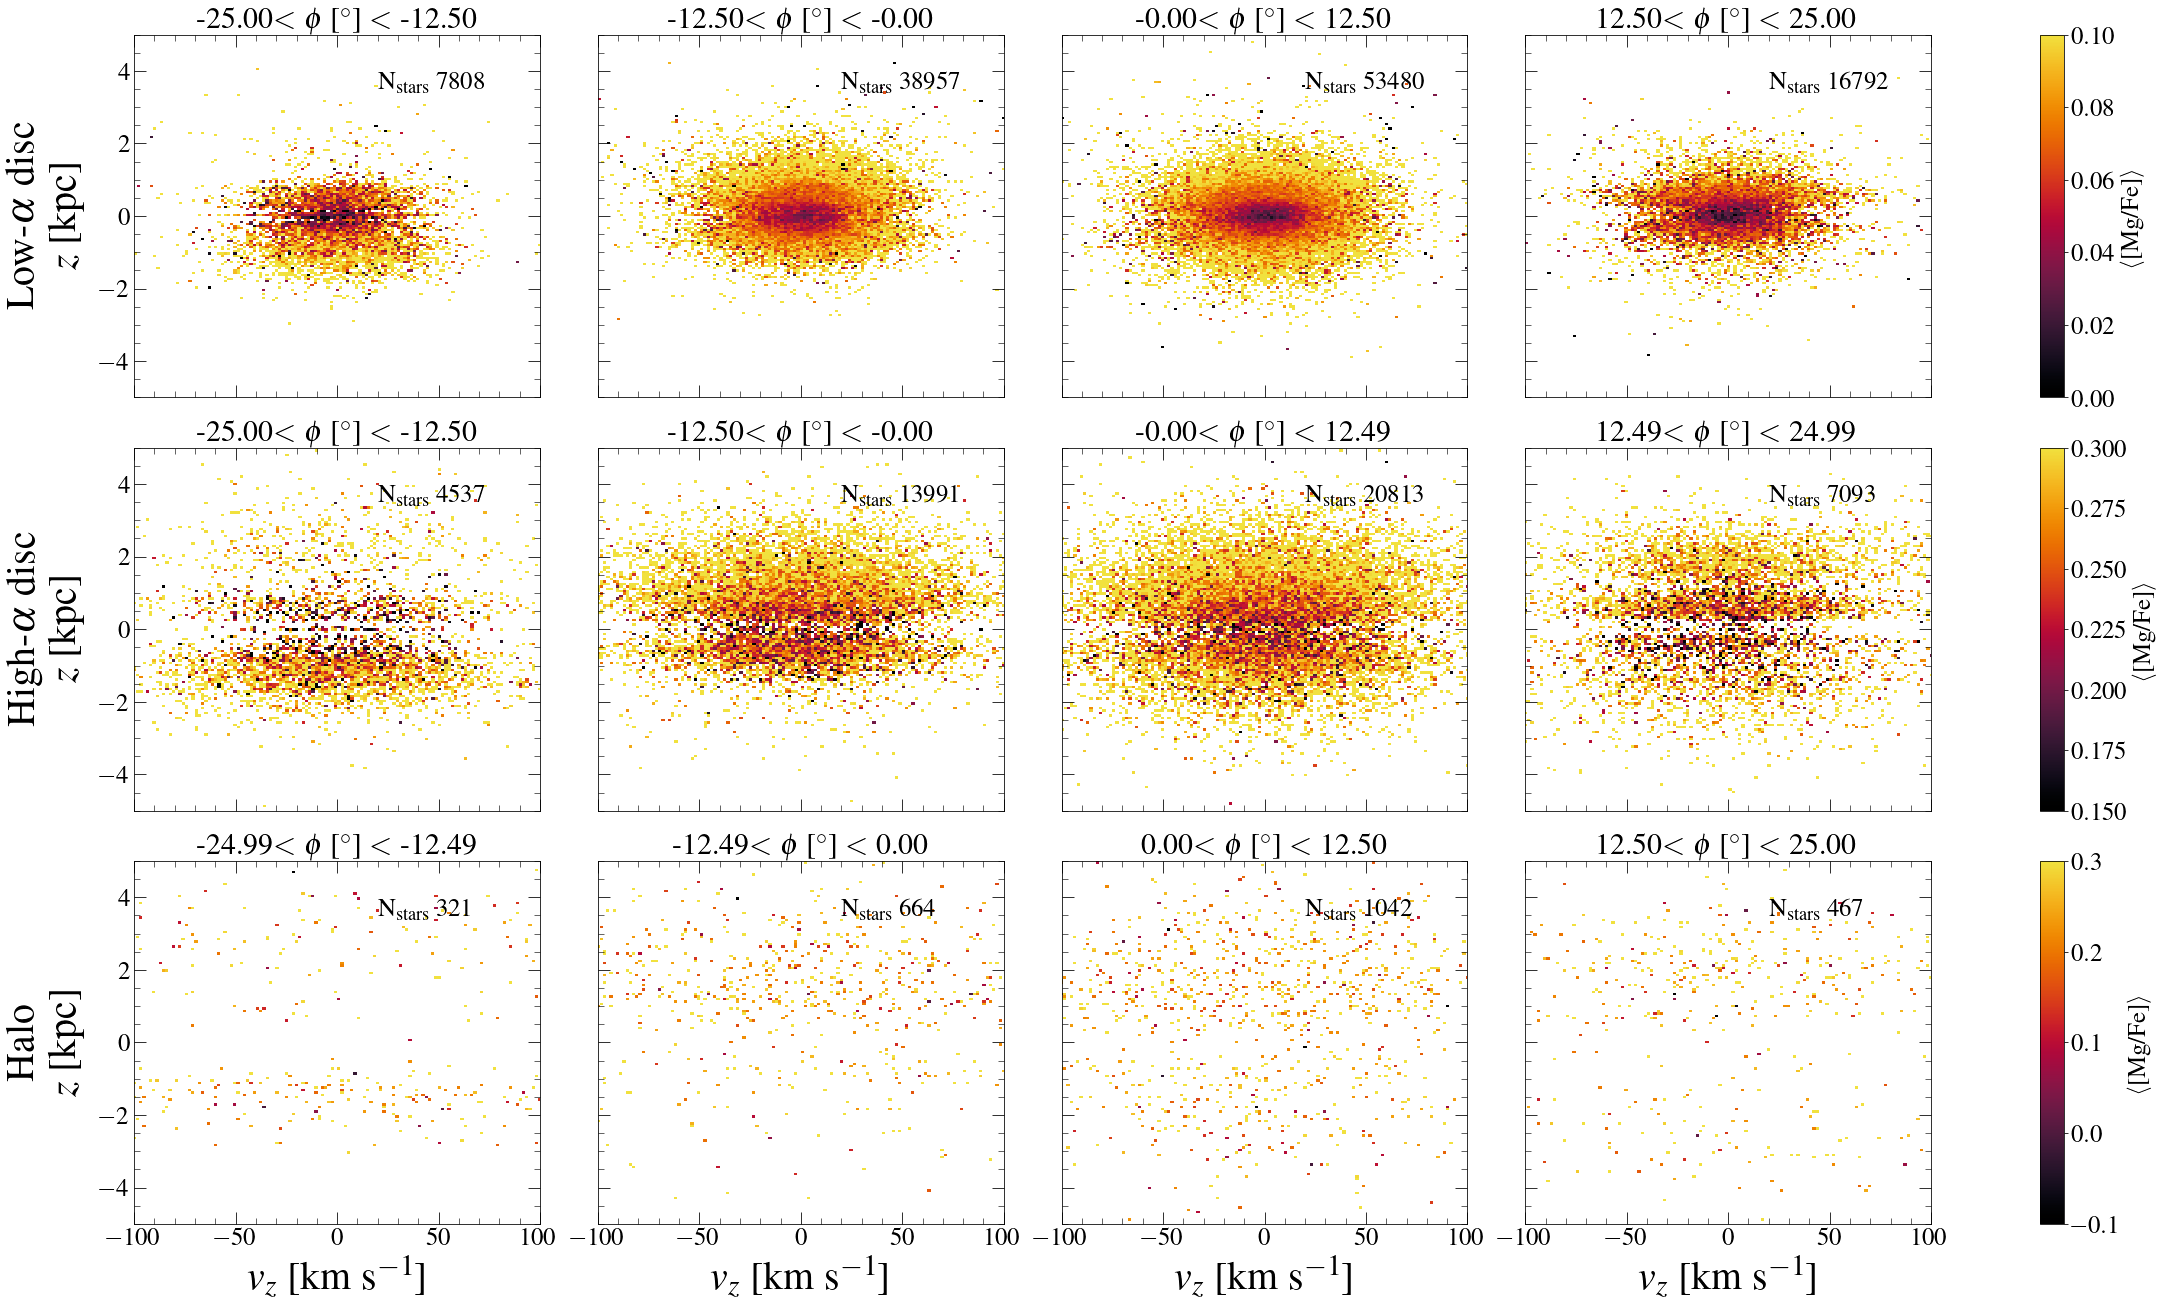

In [70]:
lowa =mask&lowa_disc_mask&(phi_rad>-25)&(phi_rad<25) &(np.abs(z)<5)&(np.abs(vz)<120)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z))
higha = mask&higha_disc_mask&(phi_rad>-25)&(phi_rad<25)&(np.abs(z)<5)&(np.abs(vz)<120)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z))
halo = mask&other_mask&(phi_rad>-25)&(phi_rad<25)&(np.abs(z)<5)&(np.abs(vz)<120)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z))

plot_3_3(phi_rad,vz,z, data['MG_FE'],lowa,higha,halo,label1=r'$\phi$ [$^{\circ}$]',\
         label2 = r'$v_{z}$ [km s$^{-1}$]', label3=r'$z$ [kpc]',\
            xlim1 = -100, xlim2 = 100, ylim1 =-5, ylim2 = 5,xnstar = 20, ynstar = 3.5,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/zvz-phi-3x3.pdf',dpi=200, bbox_inches = 'tight')


# Radial space as a function of $z$ and $\phi$

(array([9.00000e+00, 6.40000e+01, 2.44000e+02, 1.62200e+03, 3.61630e+04,
        1.16982e+05, 1.79990e+04, 9.80000e+02, 1.76000e+02, 3.20000e+01]),
 array([-454.71315618, -369.68982473, -284.66649327, -199.64316182,
        -114.61983036,  -29.59649891,   55.42683255,  140.450164  ,
         225.47349546,  310.49682692,  395.52015837]),
 <BarContainer object of 10 artists>)

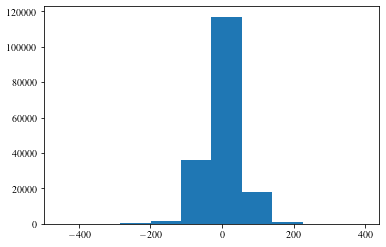

In [71]:
plt.hist(vr[mask])

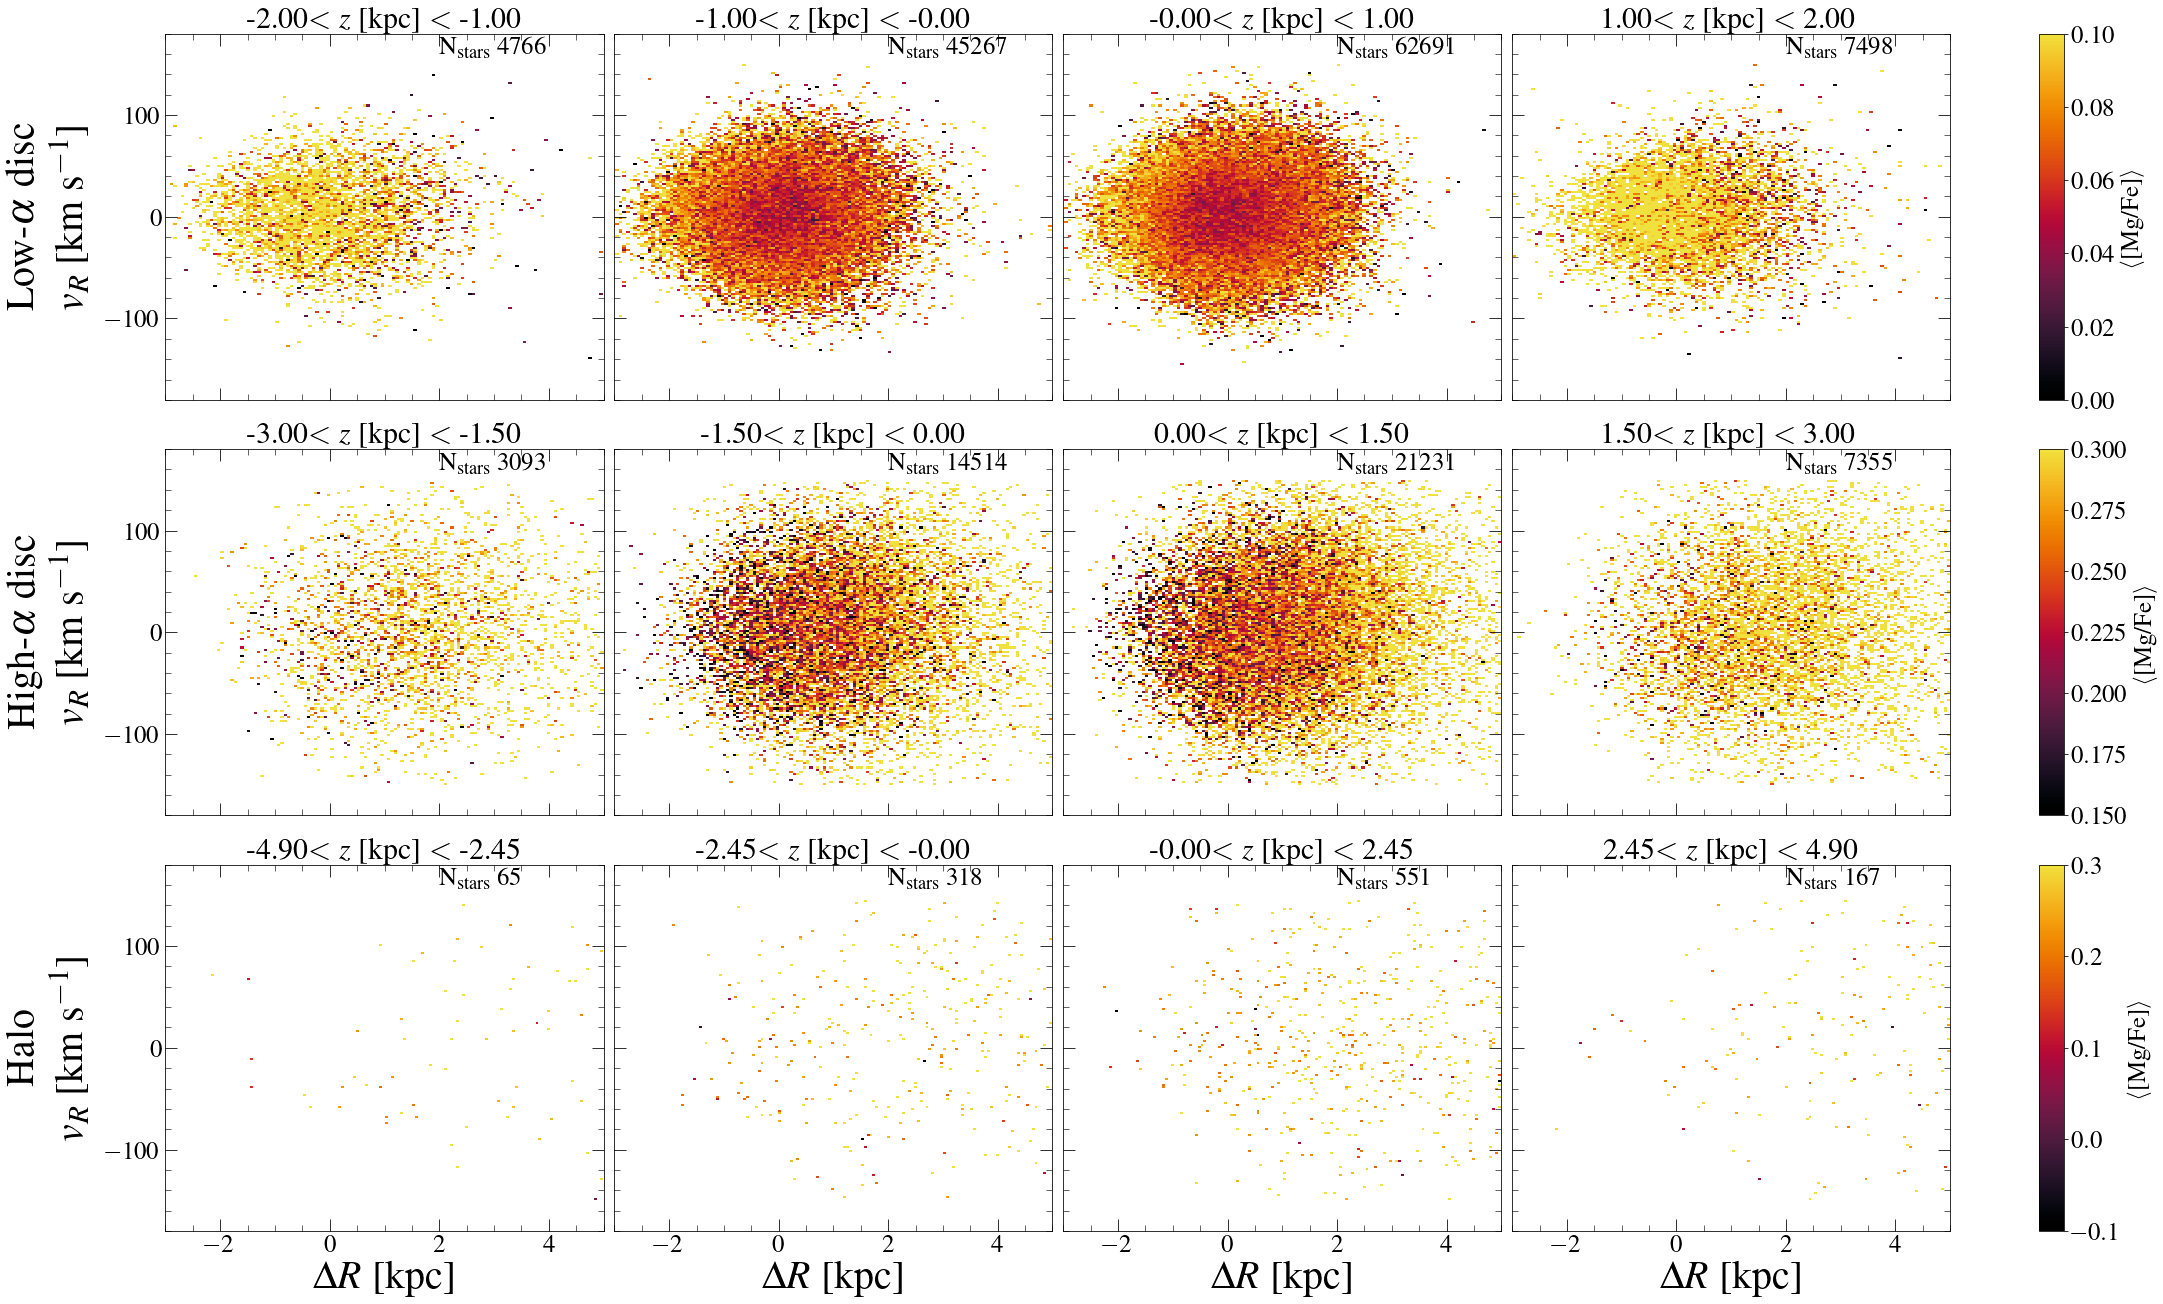

In [75]:
lowa =mask&lowa_disc_mask&(z>-2)&(z<2) &(np.abs(deltaR)<5)&(np.abs(vr)<150)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z))
higha = mask&higha_disc_mask&(z>-3)&(z<3)&(np.abs(deltaR)<5)&(np.abs(vr)<150)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z))
halo = mask&other_mask&(z>-5)&(z<5)&(np.abs(deltaR)<5)&(np.abs(vr)<150)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z))

plot_3_3(z,deltaR,vr, data['MG_FE'],lowa,higha,halo,label1=r'$z$ [kpc]',\
         label2 = r'$\Delta R$ [kpc]', label3=r'$v_{R}$ [km s$^{-1}$]',\
            xlim1 = -3, xlim2 = 5, ylim1 =-180, ylim2 = 180,xnstar = 2, ynstar = 160,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/RvR-z-3x3.pdf',dpi=200, bbox_inches = 'tight')


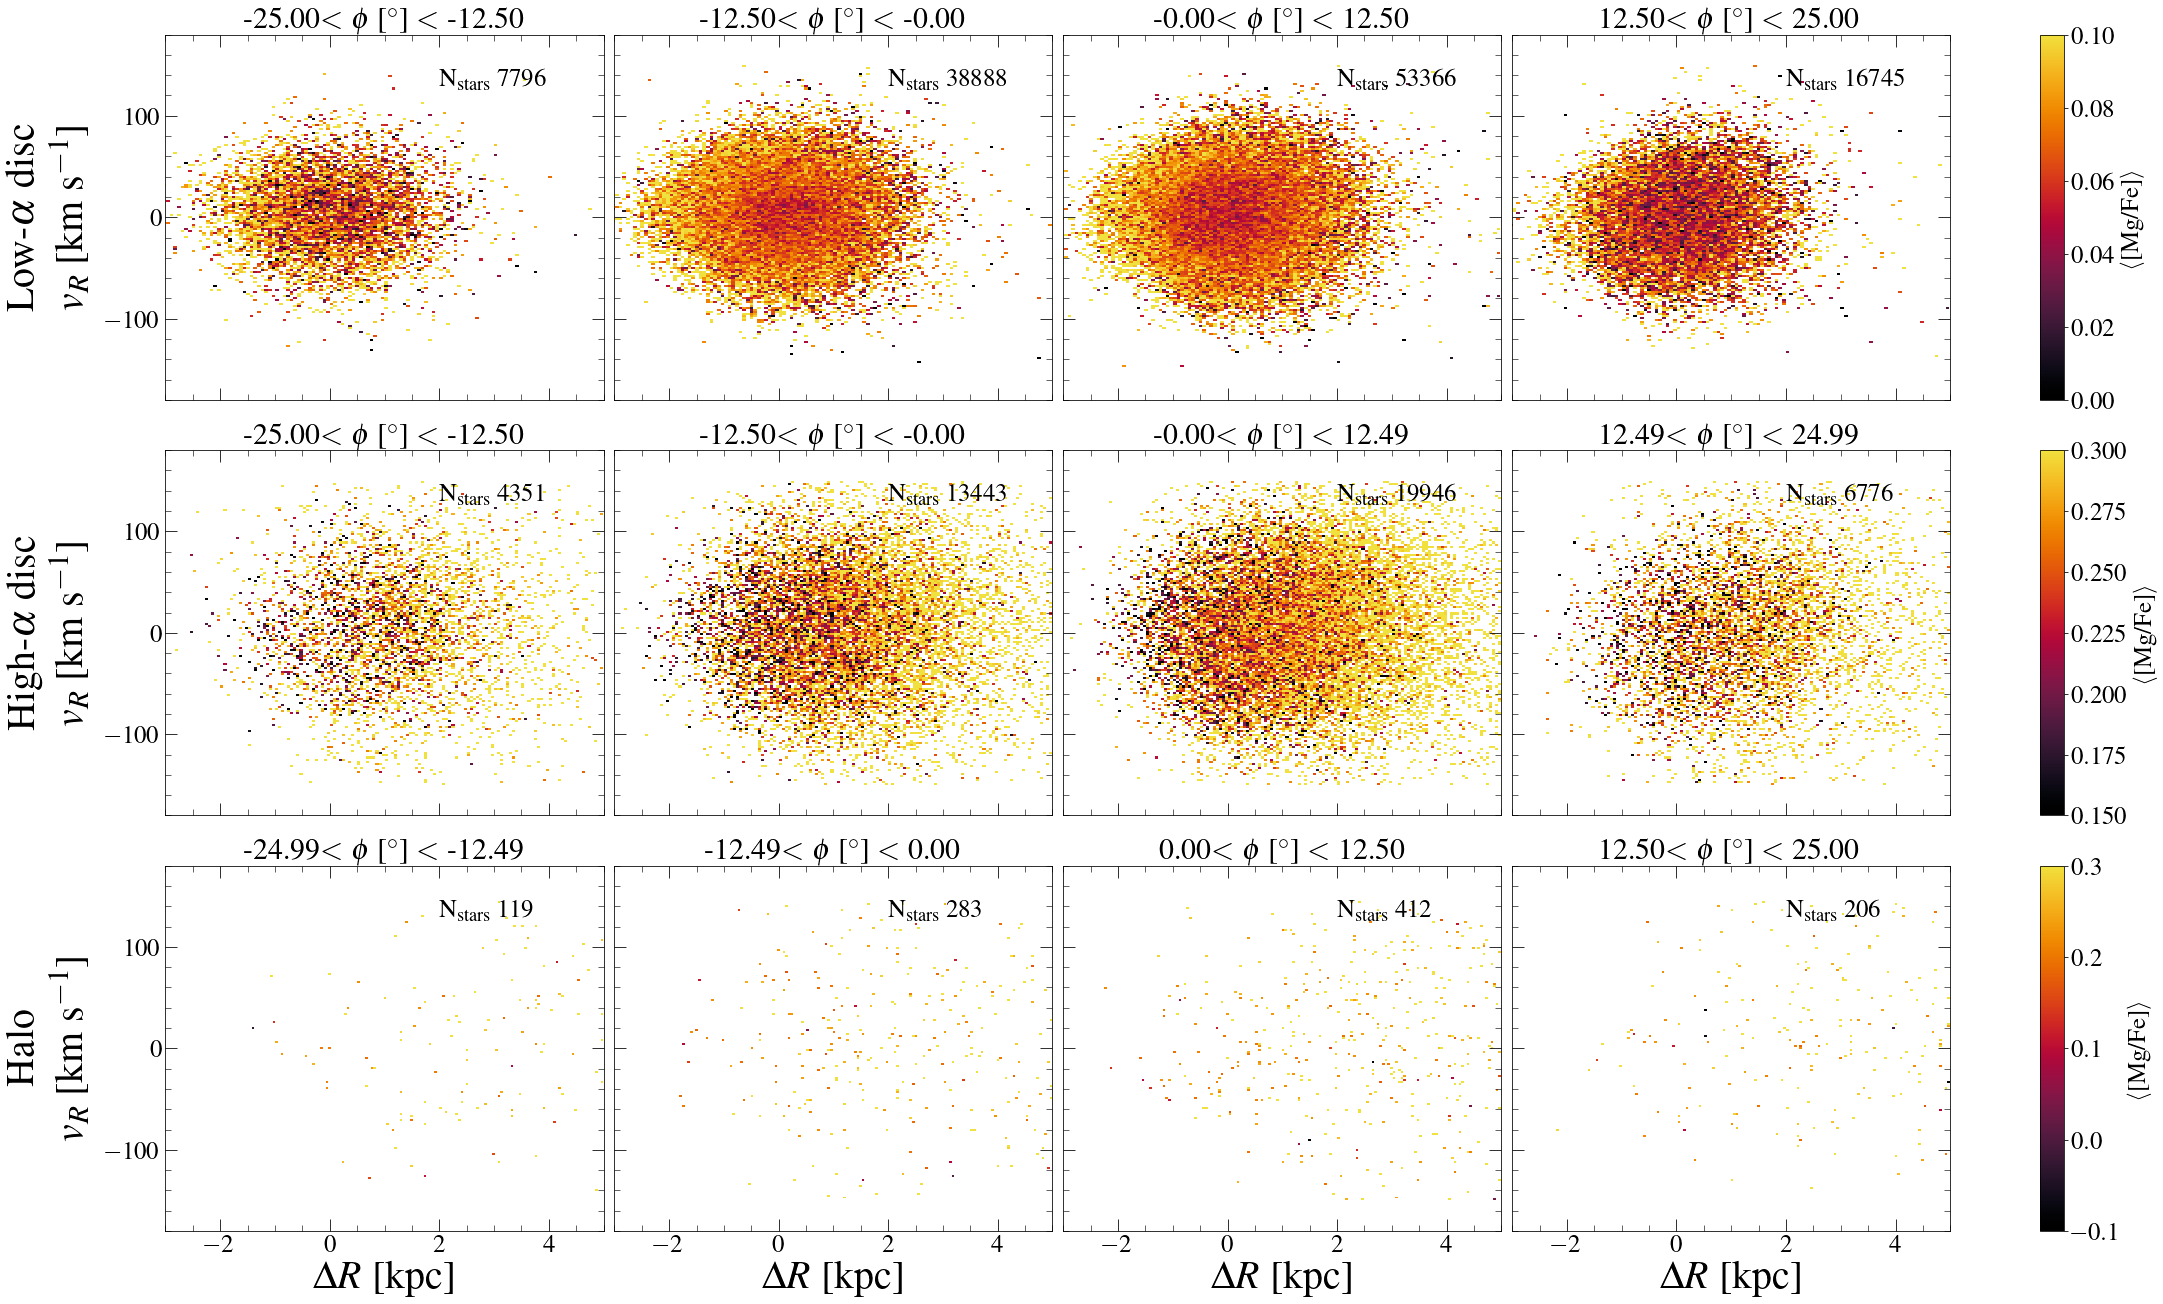

In [80]:
lowa =mask&lowa_disc_mask&(phi_rad>-25)&(phi_rad<25) &(np.abs(deltaR)<5)&(np.abs(vr)<150)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z))
higha = mask&higha_disc_mask&(phi_rad>-25)&(phi_rad<25)&(np.abs(deltaR)<5)&(np.abs(vr)<150)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z))
halo = mask&other_mask&(phi_rad>-25)&(phi_rad<25)&(np.abs(deltaR)<5)&(np.abs(vr)<150)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z))

plot_3_3(phi_rad,deltaR,vr, data['MG_FE'],lowa,higha,halo,label1=r'$\phi$ [$^{\circ}$]',\
         label2 = r'$\Delta R$ [kpc]', label3=r'$v_{R}$ [km s$^{-1}$]',\
            xlim1 = -3, xlim2 = 5, ylim1 =-180, ylim2 = 180,xnstar = 2, ynstar = 130,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/RvR-phi-3x3.pdf',dpi=200, bbox_inches = 'tight')


# Azimuth as a function of $R$ and $z$

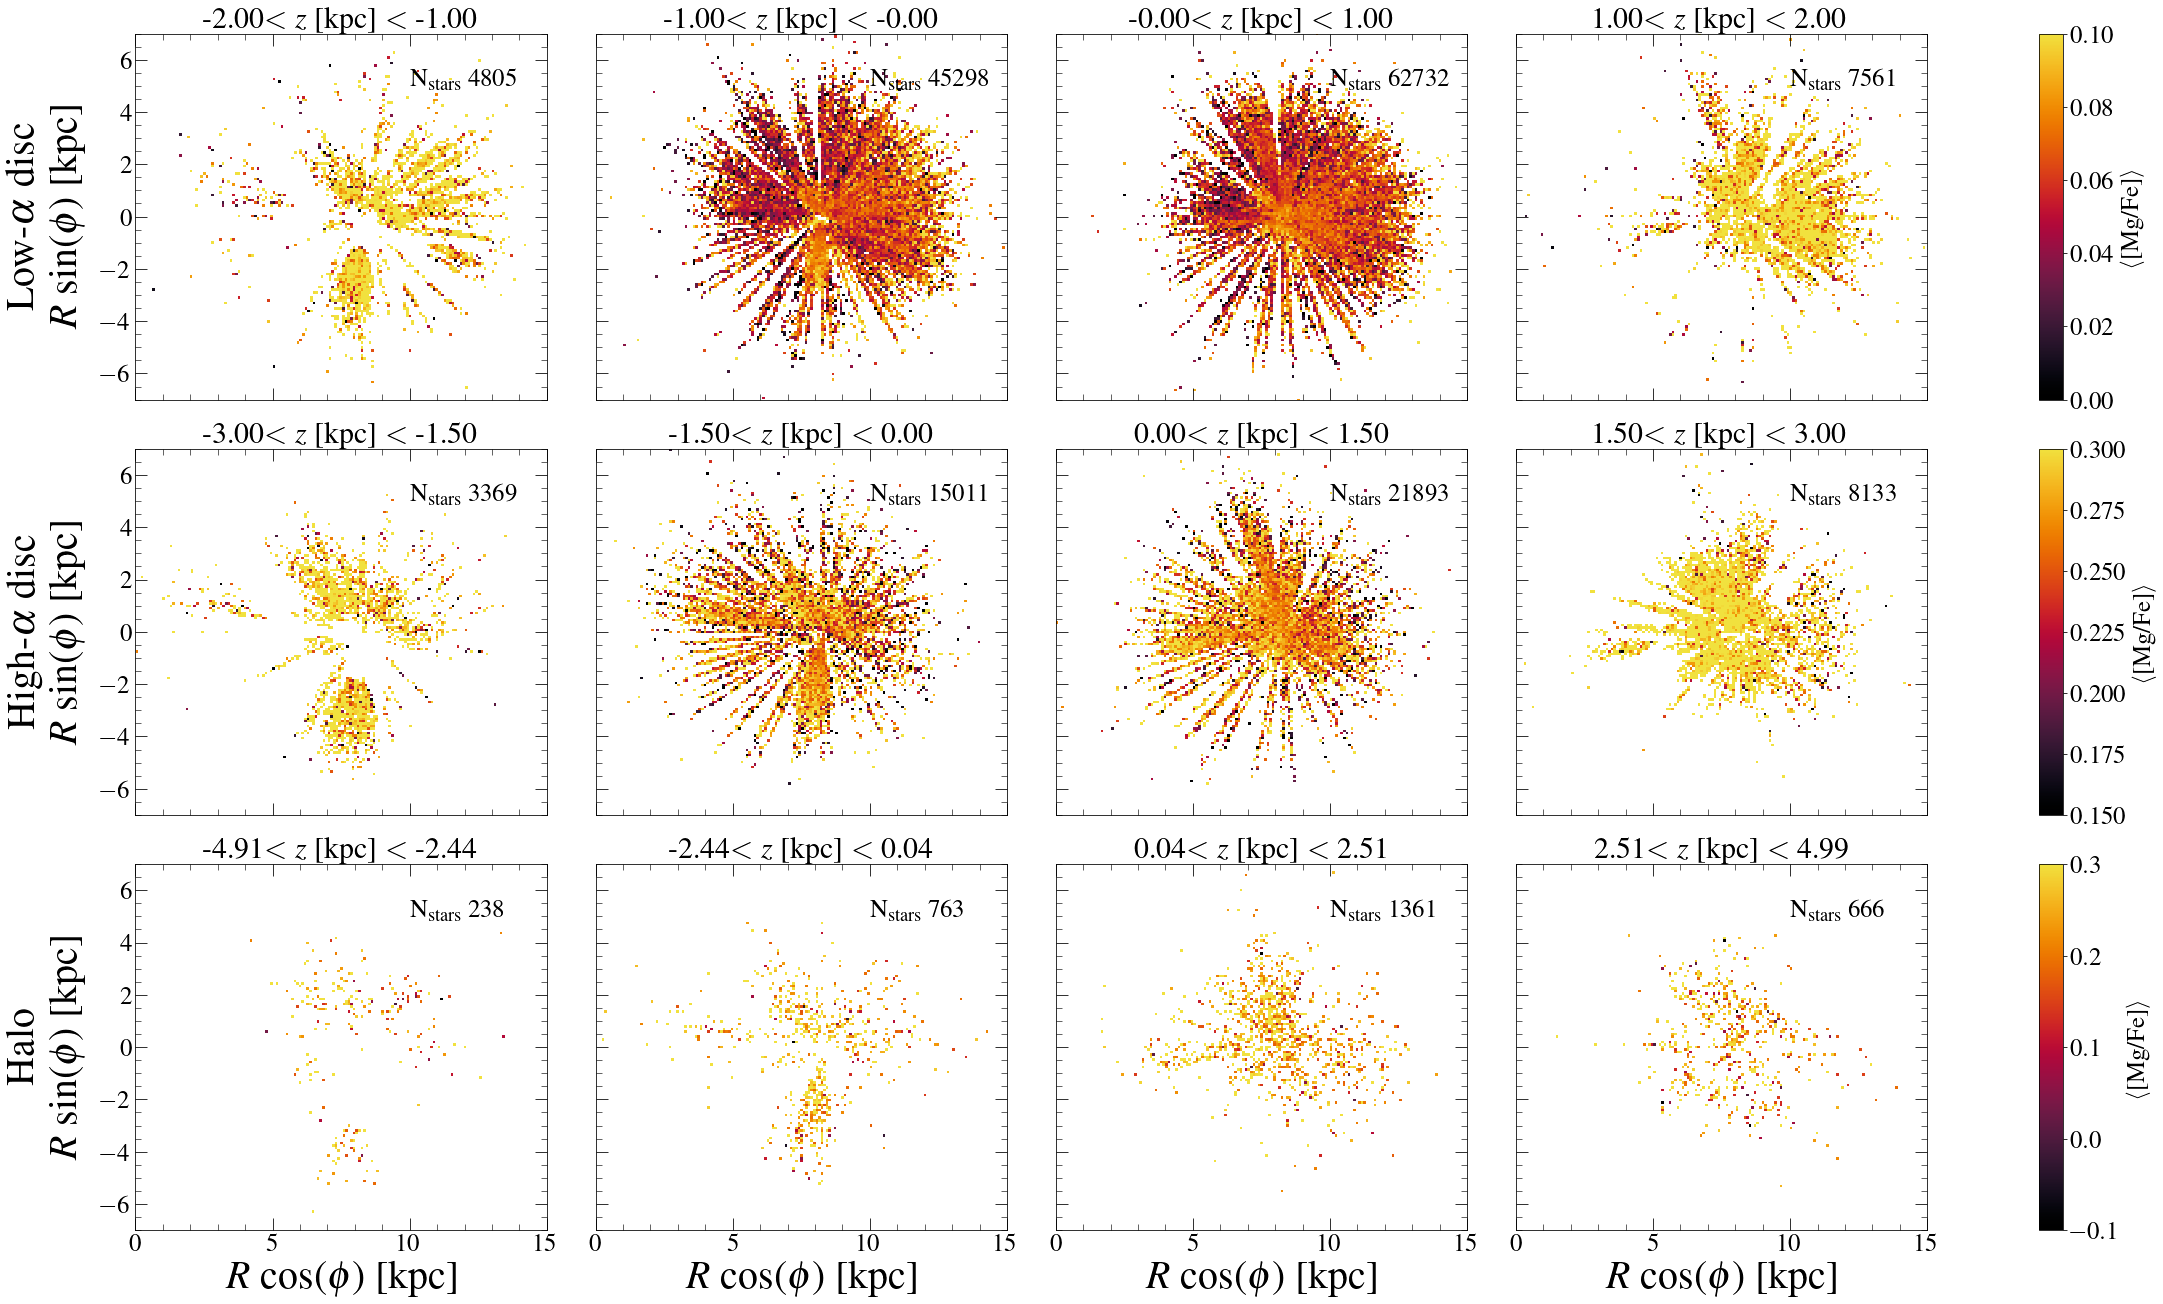

In [85]:
lowa =mask&lowa_disc_mask&(z>-2)&(z<2) &(np.abs(phi_x1)<15)&(phi_x1>0)&(np.abs(phi_y1)<8)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(phi_x1))
higha = mask&higha_disc_mask&(z>-3)&(z<3)&(np.abs(phi_x1)<15)&(phi_x1>0)&(np.abs(phi_y1)<8)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(phi_x1))
halo = mask&other_mask&(z>-5)&(z<5)&(np.abs(phi_x1)<15)&(phi_x1>0)&(np.abs(phi_y1)<8)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(phi_x1))

plot_3_3(z,phi_x1,phi_y1, data['MG_FE'],lowa,higha,halo,label1=r'$z$ [kpc]',\
         label2 = r'$R$ cos($\phi$) [kpc]', label3=r'$R$ sin($\phi$) [kpc]',\
            xlim1 = 0, xlim2 = 15, ylim1 =-7, ylim2 = 7,xnstar = 10, ynstar = 5,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/phi2-z-3x3.pdf',dpi=200, bbox_inches = 'tight')


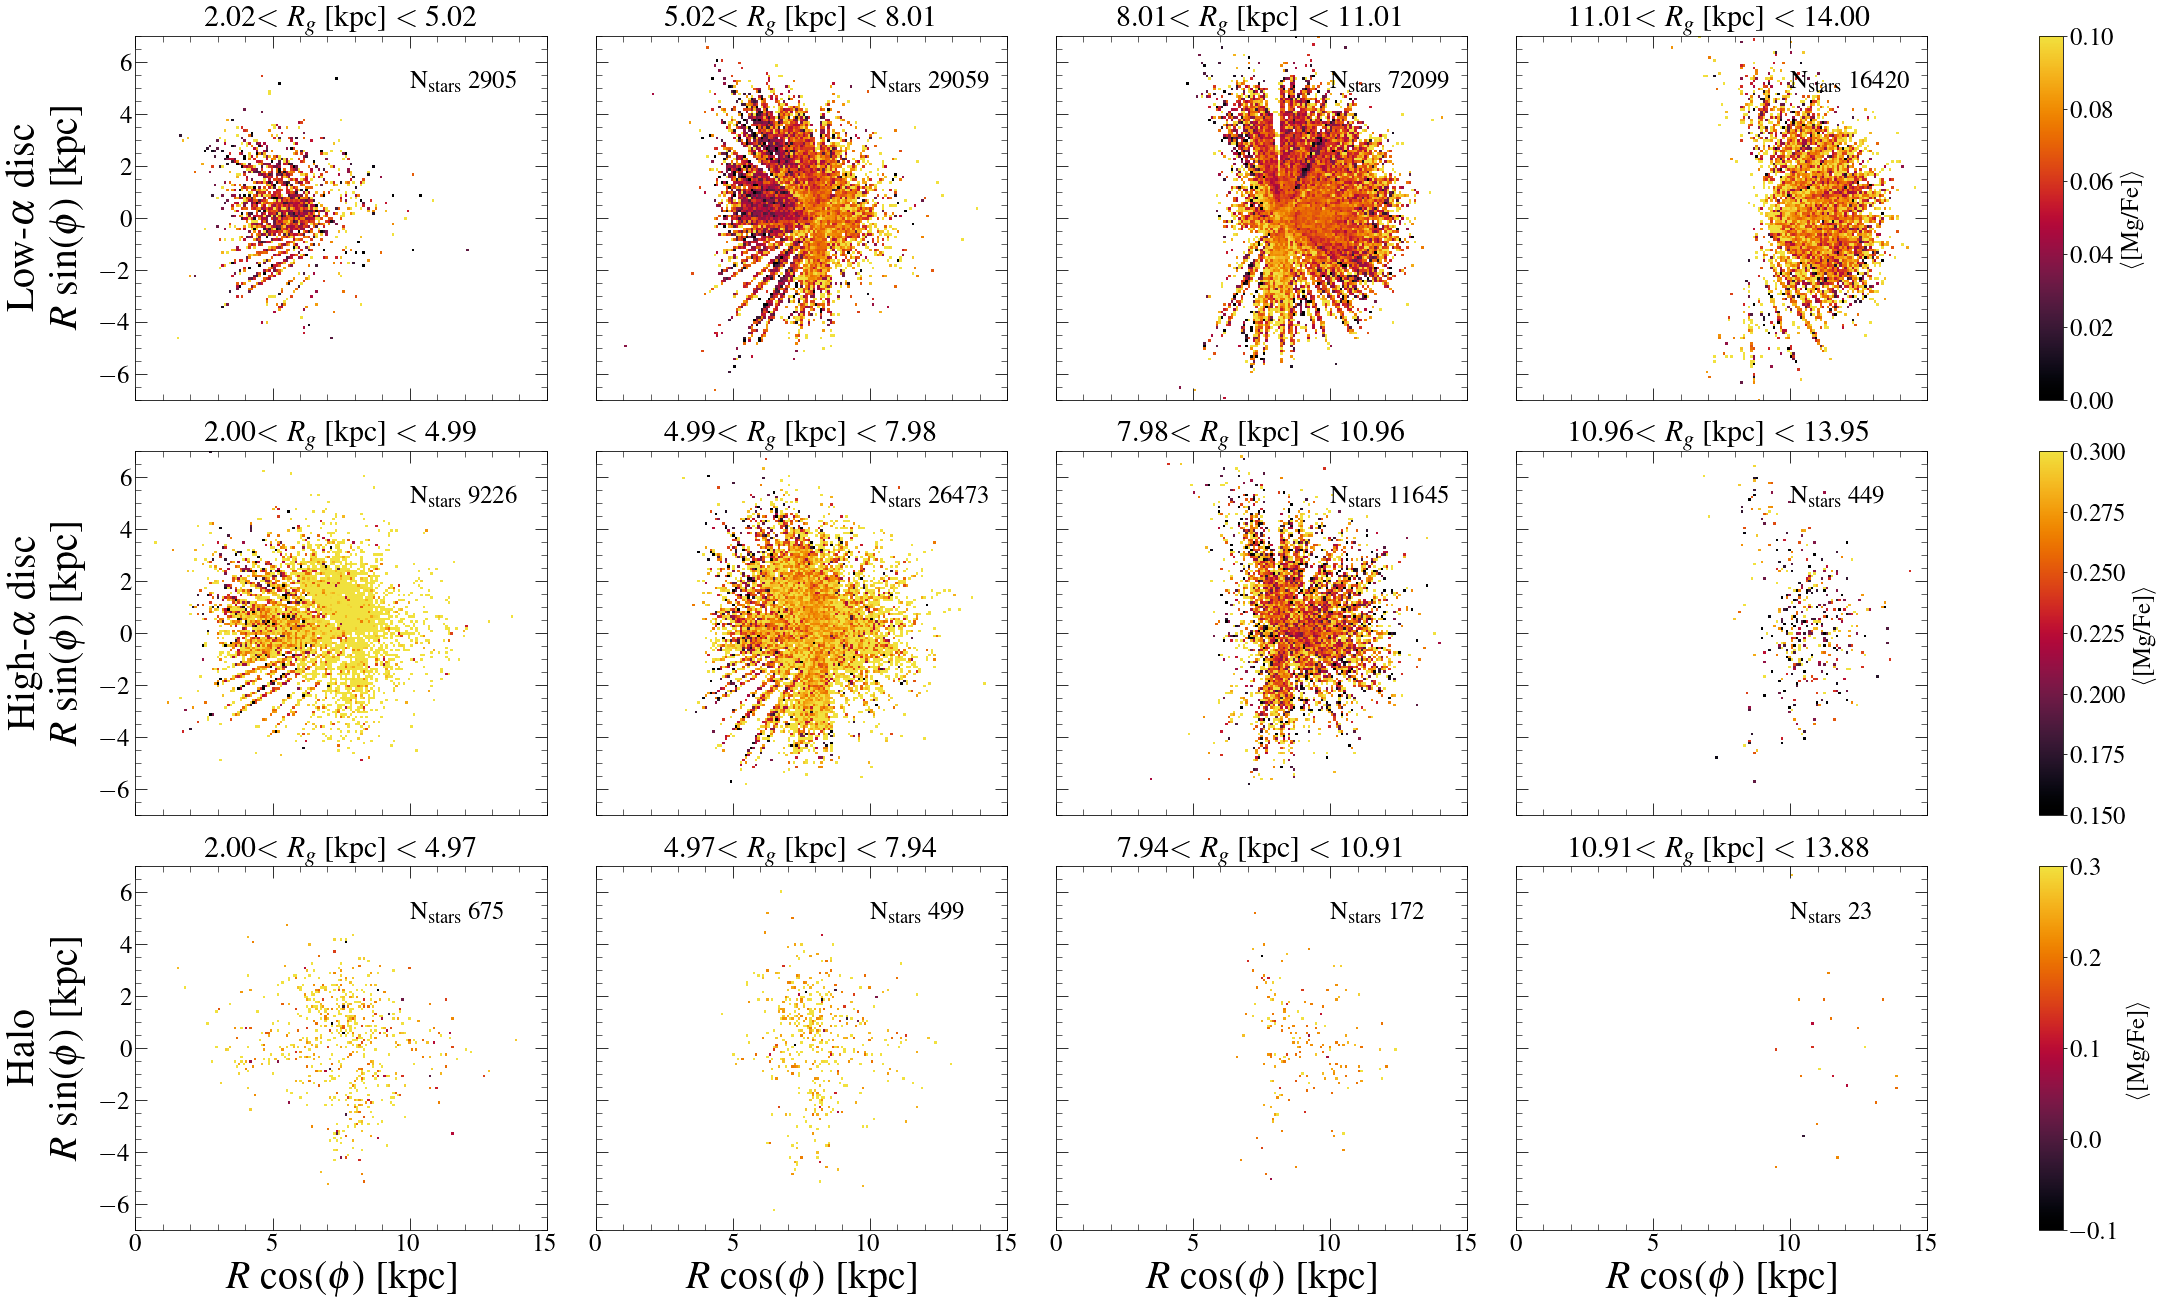

In [88]:
lowa =mask&lowa_disc_mask&(Rg>2)&(Rg<14) &(np.abs(phi_x1)<15)&(phi_x1>0)&(np.abs(phi_y1)<8)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(phi_x1))
higha = mask&higha_disc_mask&(Rg>2)&(Rg<14)&(np.abs(phi_x1)<15)&(phi_x1>0)&(np.abs(phi_y1)<8)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(phi_x1))
halo = mask&other_mask&(Rg>2)&(Rg<14)&(np.abs(phi_x1)<15)&(phi_x1>0)&(np.abs(phi_y1)<8)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(phi_x1))

plot_3_3(Rg,phi_x1,phi_y1, data['MG_FE'],lowa,higha,halo,label1=r'$R_g$ [kpc]',\
         label2 = r'$R$ cos($\phi$) [kpc]', label3=r'$R$ sin($\phi$) [kpc]',\
            xlim1 = 0, xlim2 = 15, ylim1 =-7, ylim2 = 7,xnstar = 10, ynstar = 5,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/phi2-Rg-3x3.pdf',dpi=200, bbox_inches = 'tight')


# Now do the same with orbits

In [93]:
def plot_3_3(var1, var2, var3, abun, mask1, mask2, mask3,n=5,nbins=91,xfe_label=r'$\langle$[Mg/Fe]$\rangle$',\
            label1=r'$\Delta R$ [kpc]', label2 = r'$R_{g}$ [kpc]', label3=r'$z_{\mathrm{max}}$ [kpc]',\
            xlim1 = 0, xlim2 = 15, ylim1 =0, ylim2 = 8,xnstar = 9, ynstar = 7):
    """
    Take three variables (say J) and 3 samples (say high-/low-alpha discs and halo) and plot two variables conditioned
    on the other. 
    """
    
    fig, all_axes = plt.subplots(3, 4, constrained_layout=True, figsize=(30, 18), sharex=True, sharey=True, rasterized=True)
    
    # for mask1
    xs = np.around(np.linspace(np.min(var1[mask1]),np.max(var1[mask1]),n),decimals=2)
    # for mask2
    xs2 = np.around(np.linspace(np.min(var1[mask2]),np.max(var1[mask2]),n),decimals=2)
    # for mask3
    xs3 = np.around(np.linspace(np.min(var1[mask3]),np.max(var1[mask3]),n),decimals=2)   
    
    # set up an array of the x grids to loop over
    exis = np.array((xs,xs2,xs3))
    
    for indx, i in enumerate(exis):
        axis = all_axes[indx]
        for indx2, k in enumerate(i[:-1]):
                # create a mask for every loop
                if k<i[-1] and indx==0:
                        mask_loop = (var1[mask1]>k)&(var1[mask1]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask1]),np.max(var2[mask1]),nbins)
                        biny = np.linspace(np.min(var3[mask1]),np.max(var3[mask1]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask1][mask_loop],var3[mask1][mask_loop], abun[mask1][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.0,vmax=0.1)         
                        ax.set_xlim(xlim1,xlim2)
                        ax.set_ylim(ylim1,ylim2)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(xnstar,ynstar,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask1][mask_loop])),fontsize=25)
                        ax.set_title(r'' +str('%5.2f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.2f' %i[indx2+1]),fontsize=20)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()
                        
                if k<i[-1] and indx==1:
                        mask_loop = (var1[mask2]>k)&(var1[mask2]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask2]),np.max(var2[mask2]),nbins)
                        biny = np.linspace(np.min(var3[mask2]),np.max(var3[mask2]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask2][mask_loop],var3[mask2][mask_loop], abun[mask2][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=0.15,vmax=0.3)         
                        ax.set_xlim(xlim1,xlim2)
                        ax.set_ylim(ylim1,ylim2)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(xnstar,ynstar,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask2][mask_loop])),fontsize=25)
                        ax.set_title(r'' +str('%5.2f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.2f' %i[indx2+1]),fontsize=20)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()

                if k<i[-1] and indx==2:
                        mask_loop = (var1[mask3]>k)&(var1[mask3]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask3]),np.max(var2[mask3]),nbins)
                        biny = np.linspace(np.min(var3[mask3]),np.max(var3[mask3]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask3][mask_loop],var3[mask3][mask_loop], abun[mask3][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.1,vmax=0.3)         
                        ax.set_xlim(xlim1,xlim2)
                        ax.set_ylim(ylim1,ylim2)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(xnstar,ynstar,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask3][mask_loop])),fontsize=25)
                        ax.set_title(r'' +str('%5.2f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.2f' %i[indx2+1]),fontsize=20)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()
                else:
                    pass
        cbar = fig.colorbar(color, ax = axis, aspect=15)
        cbar.set_label(label=xfe_label,fontsize=25)
        cbar.ax.tick_params(labelsize=25)

    for ax in all_axes[-1]:
        ax.set_xlabel(label2,fontsize=30)

    all_axes[0,0].set_ylabel(r'Low-$\alpha$ disc' +' \n '+str(label3),fontsize=30,labelpad=15)
    all_axes[1,0].set_ylabel(r'High-$\alpha$ disc' +' \n '+str(label3),fontsize=30,labelpad=15)
    all_axes[2,0].set_ylabel(r'Halo' +' \n '+str(label3),fontsize=30,labelpad=15)
  

# Vertical

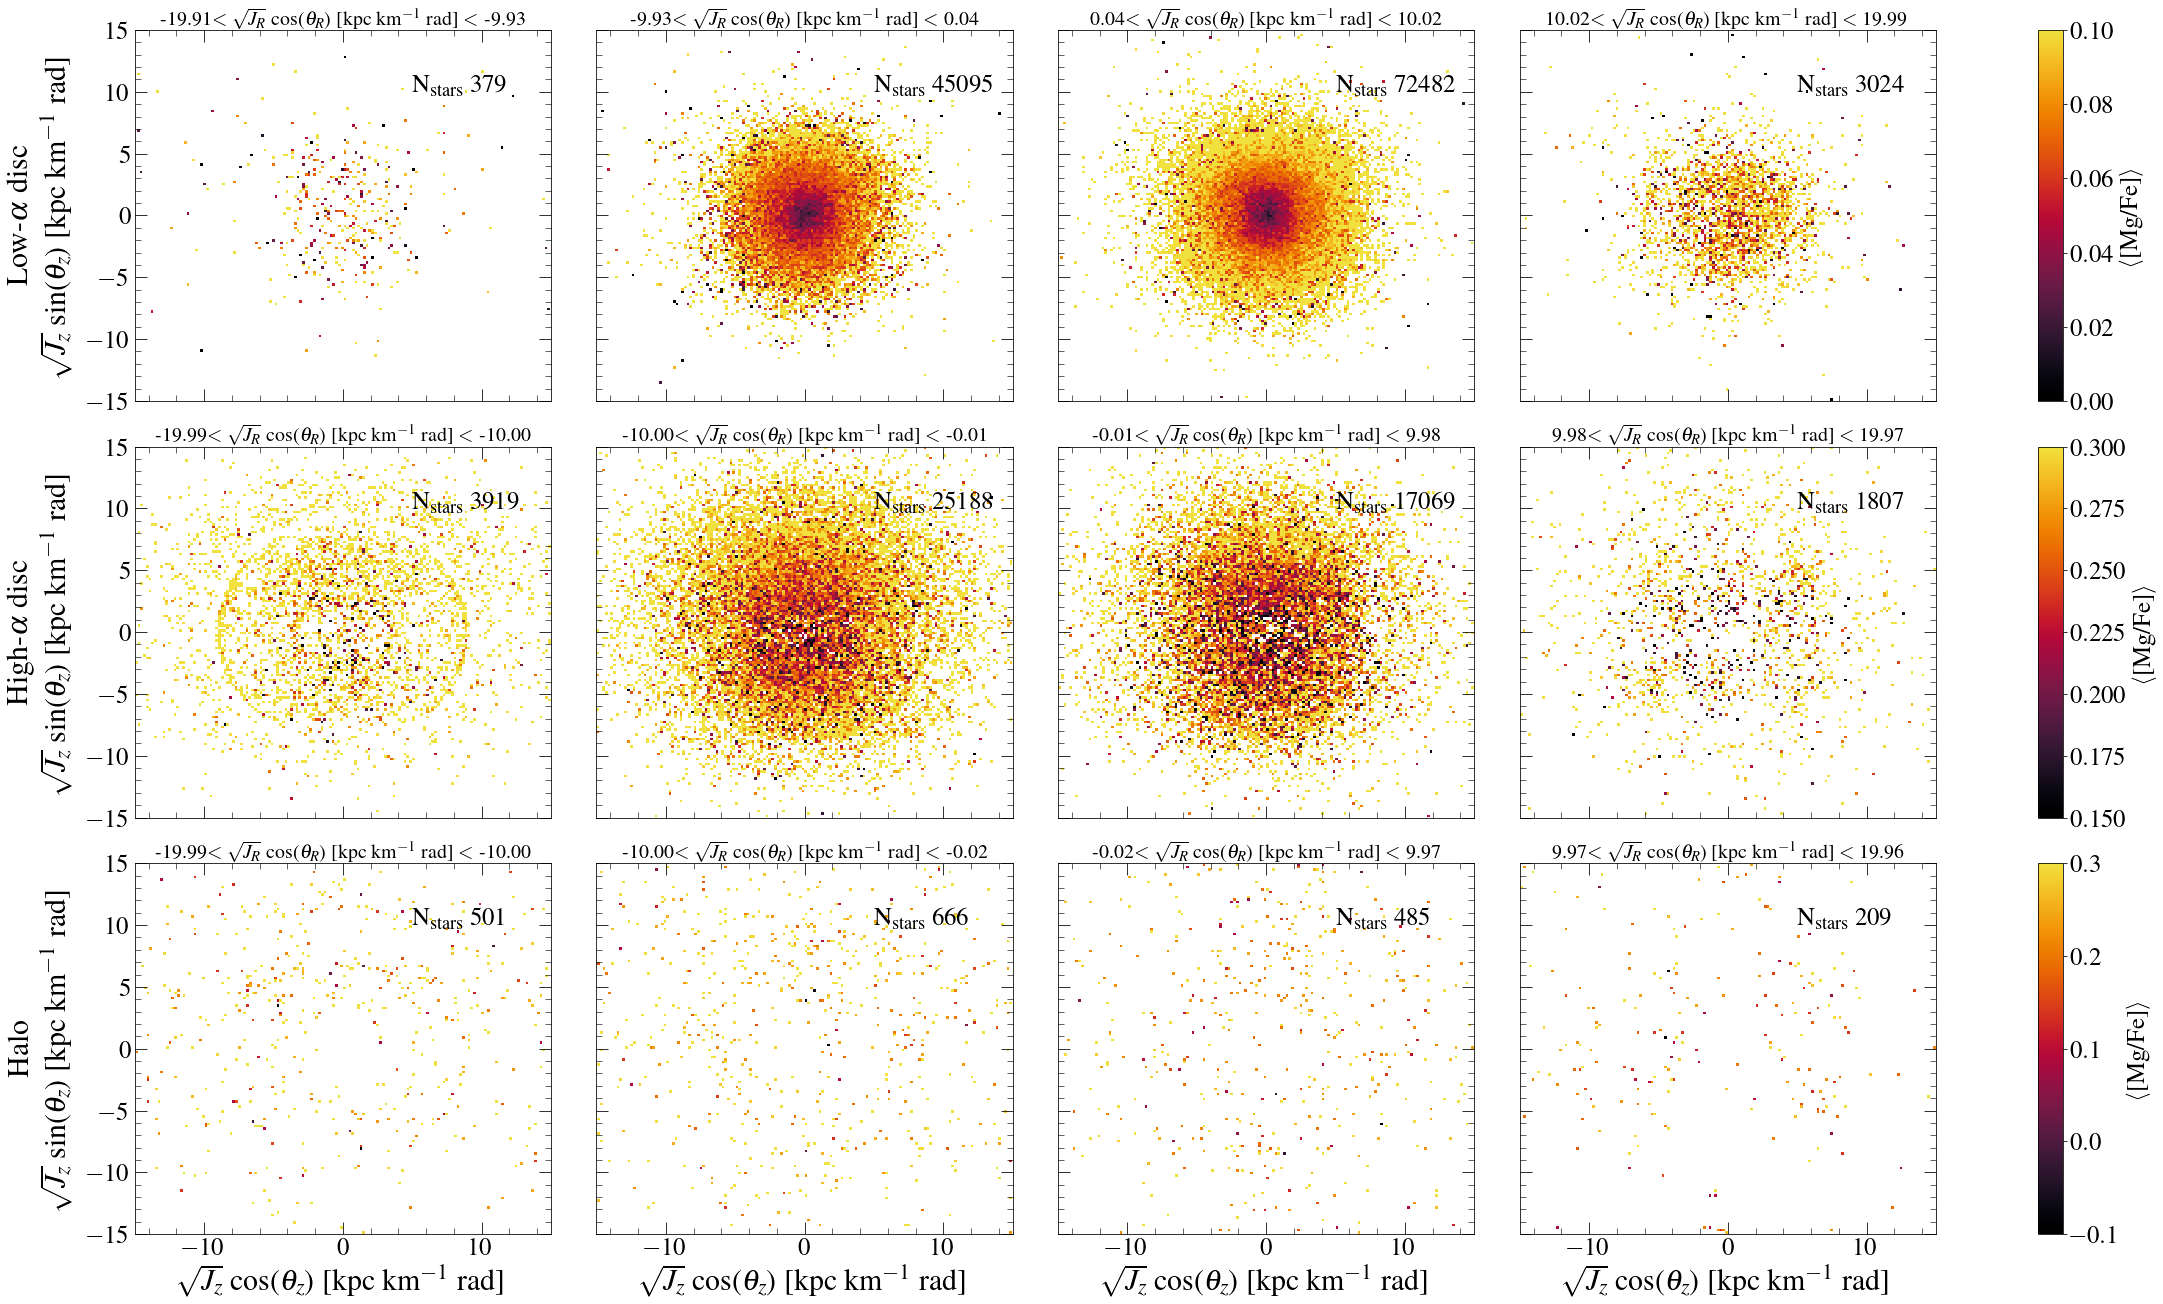

In [96]:
lowa =mask&lowa_disc_mask&(R_x>-20)&(R_x<20) &(np.abs(z_x)<15)&(np.abs(z_y)<15)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z_x))
higha = mask&higha_disc_mask&(R_x>-20)&(R_x<20)&(np.abs(z_x)<15)&(np.abs(z_y)<15)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z_x))
halo = mask&other_mask&(R_x>-20)&(R_x<20)&(np.abs(z_x)<15)&(np.abs(z_y)<15)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z_x))

plot_3_3(R_x,z_x,z_y, data['MG_FE'],lowa,higha,halo,label1=r'$\sqrt{J_{R}}$ cos($\theta_{R}$) [kpc km$^{-1}$ rad]',\
         label2 = r'$\sqrt{J_{z}}$ cos($\theta_{z}$) [kpc km$^{-1}$ rad]', label3=r'$\sqrt{J_{z}}$ sin($\theta_{z}$) [kpc km$^{-1}$ rad]',\
            xlim1 = -15, xlim2 = 15, ylim1 =-15, ylim2 = 15,xnstar = 5, ynstar = 10,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/orbits-vertical-radial-3x3.pdf',dpi=200, bbox_inches = 'tight')


(array([1.2400e+02, 4.7600e+02, 1.1490e+03, 2.9330e+03, 1.0458e+04,
        3.6035e+04, 8.0470e+04, 3.8597e+04, 2.3520e+03, 1.7000e+01]),
 array([ 1.17460365,  7.76866347, 14.36272329, 20.95678311, 27.55084293,
        34.14490275, 40.73896257, 47.33302239, 53.92708221, 60.52114203,
        67.11520185]),
 <BarContainer object of 10 artists>)

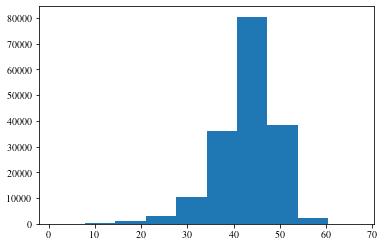

In [98]:
phi_diag = np.sqrt(phi_x2**2+phi_y2**2)

plt.hist(phi_diag[mask])

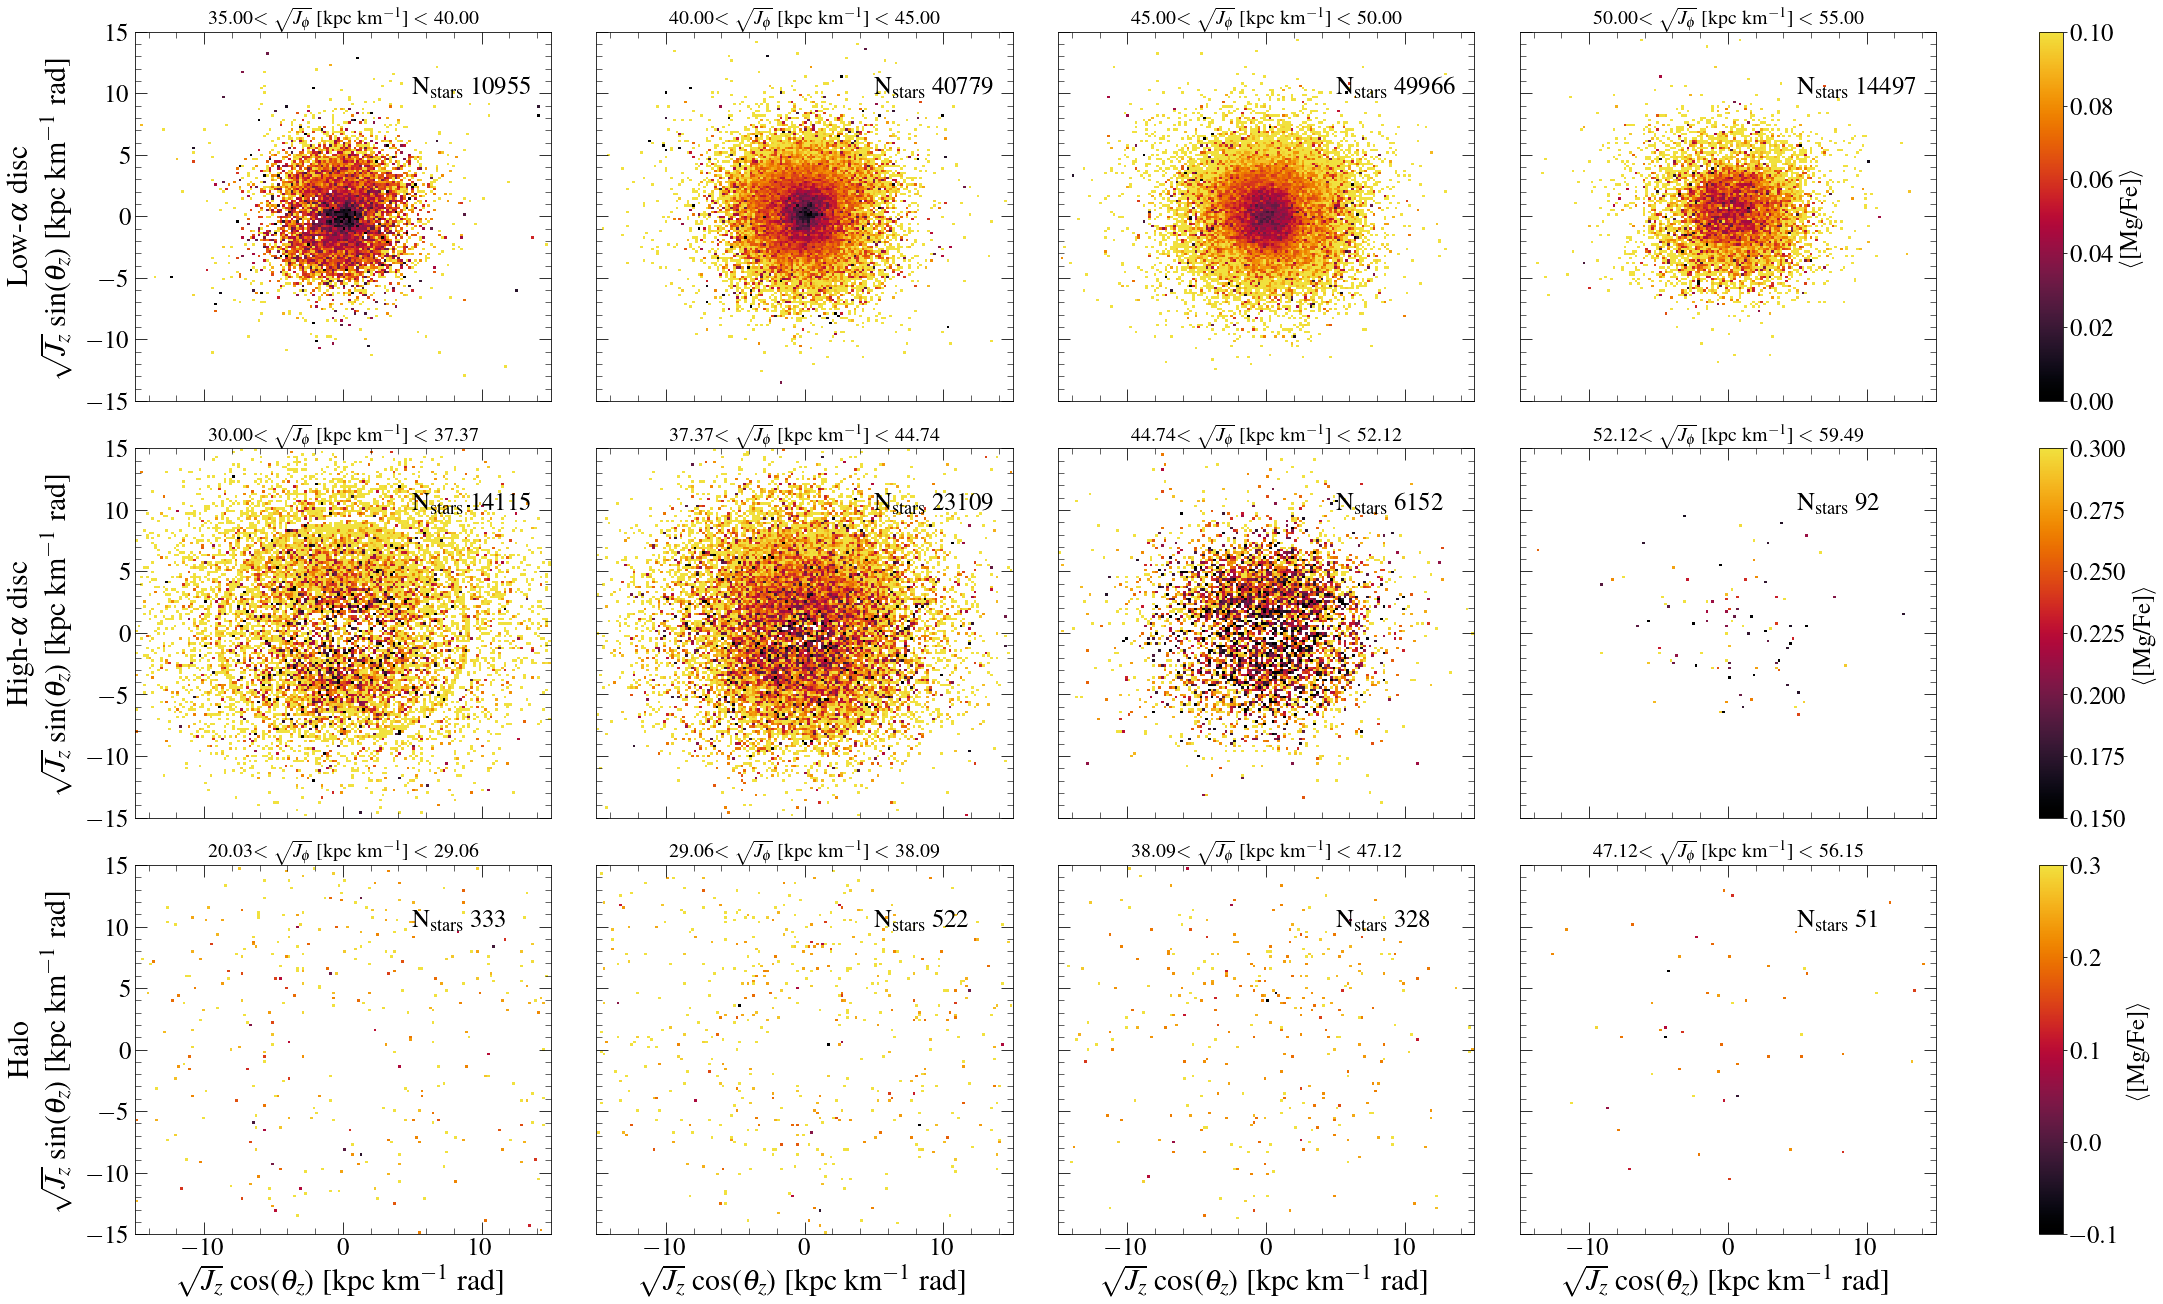

In [100]:
lowa =mask&lowa_disc_mask&(phi_diag>35)&(phi_diag<55) &(np.abs(z_x)<15)&(np.abs(z_y)<15)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z_x))
higha = mask&higha_disc_mask&(phi_diag>30)&(phi_diag<60)&(np.abs(z_x)<15)&(np.abs(z_y)<15)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z_x))
halo = mask&other_mask&(phi_diag>20)&(phi_diag<60)&(np.abs(z_x)<15)&(np.abs(z_y)<15)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(z_x))

plot_3_3(phi_diag,z_x,z_y, data['MG_FE'],lowa,higha,halo,label1=r'$\sqrt{J_{\phi}}$ [kpc km$^{-1}$]',\
         label2 = r'$\sqrt{J_{z}}$ cos($\theta_{z}$) [kpc km$^{-1}$ rad]', label3=r'$\sqrt{J_{z}}$ sin($\theta_{z}$) [kpc km$^{-1}$ rad]',\
            xlim1 = -15, xlim2 = 15, ylim1 =-15, ylim2 = 15,xnstar = 5, ynstar = 10,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/orbits-vertical-azimuth-3x3.pdf',dpi=200, bbox_inches = 'tight')


# Radial

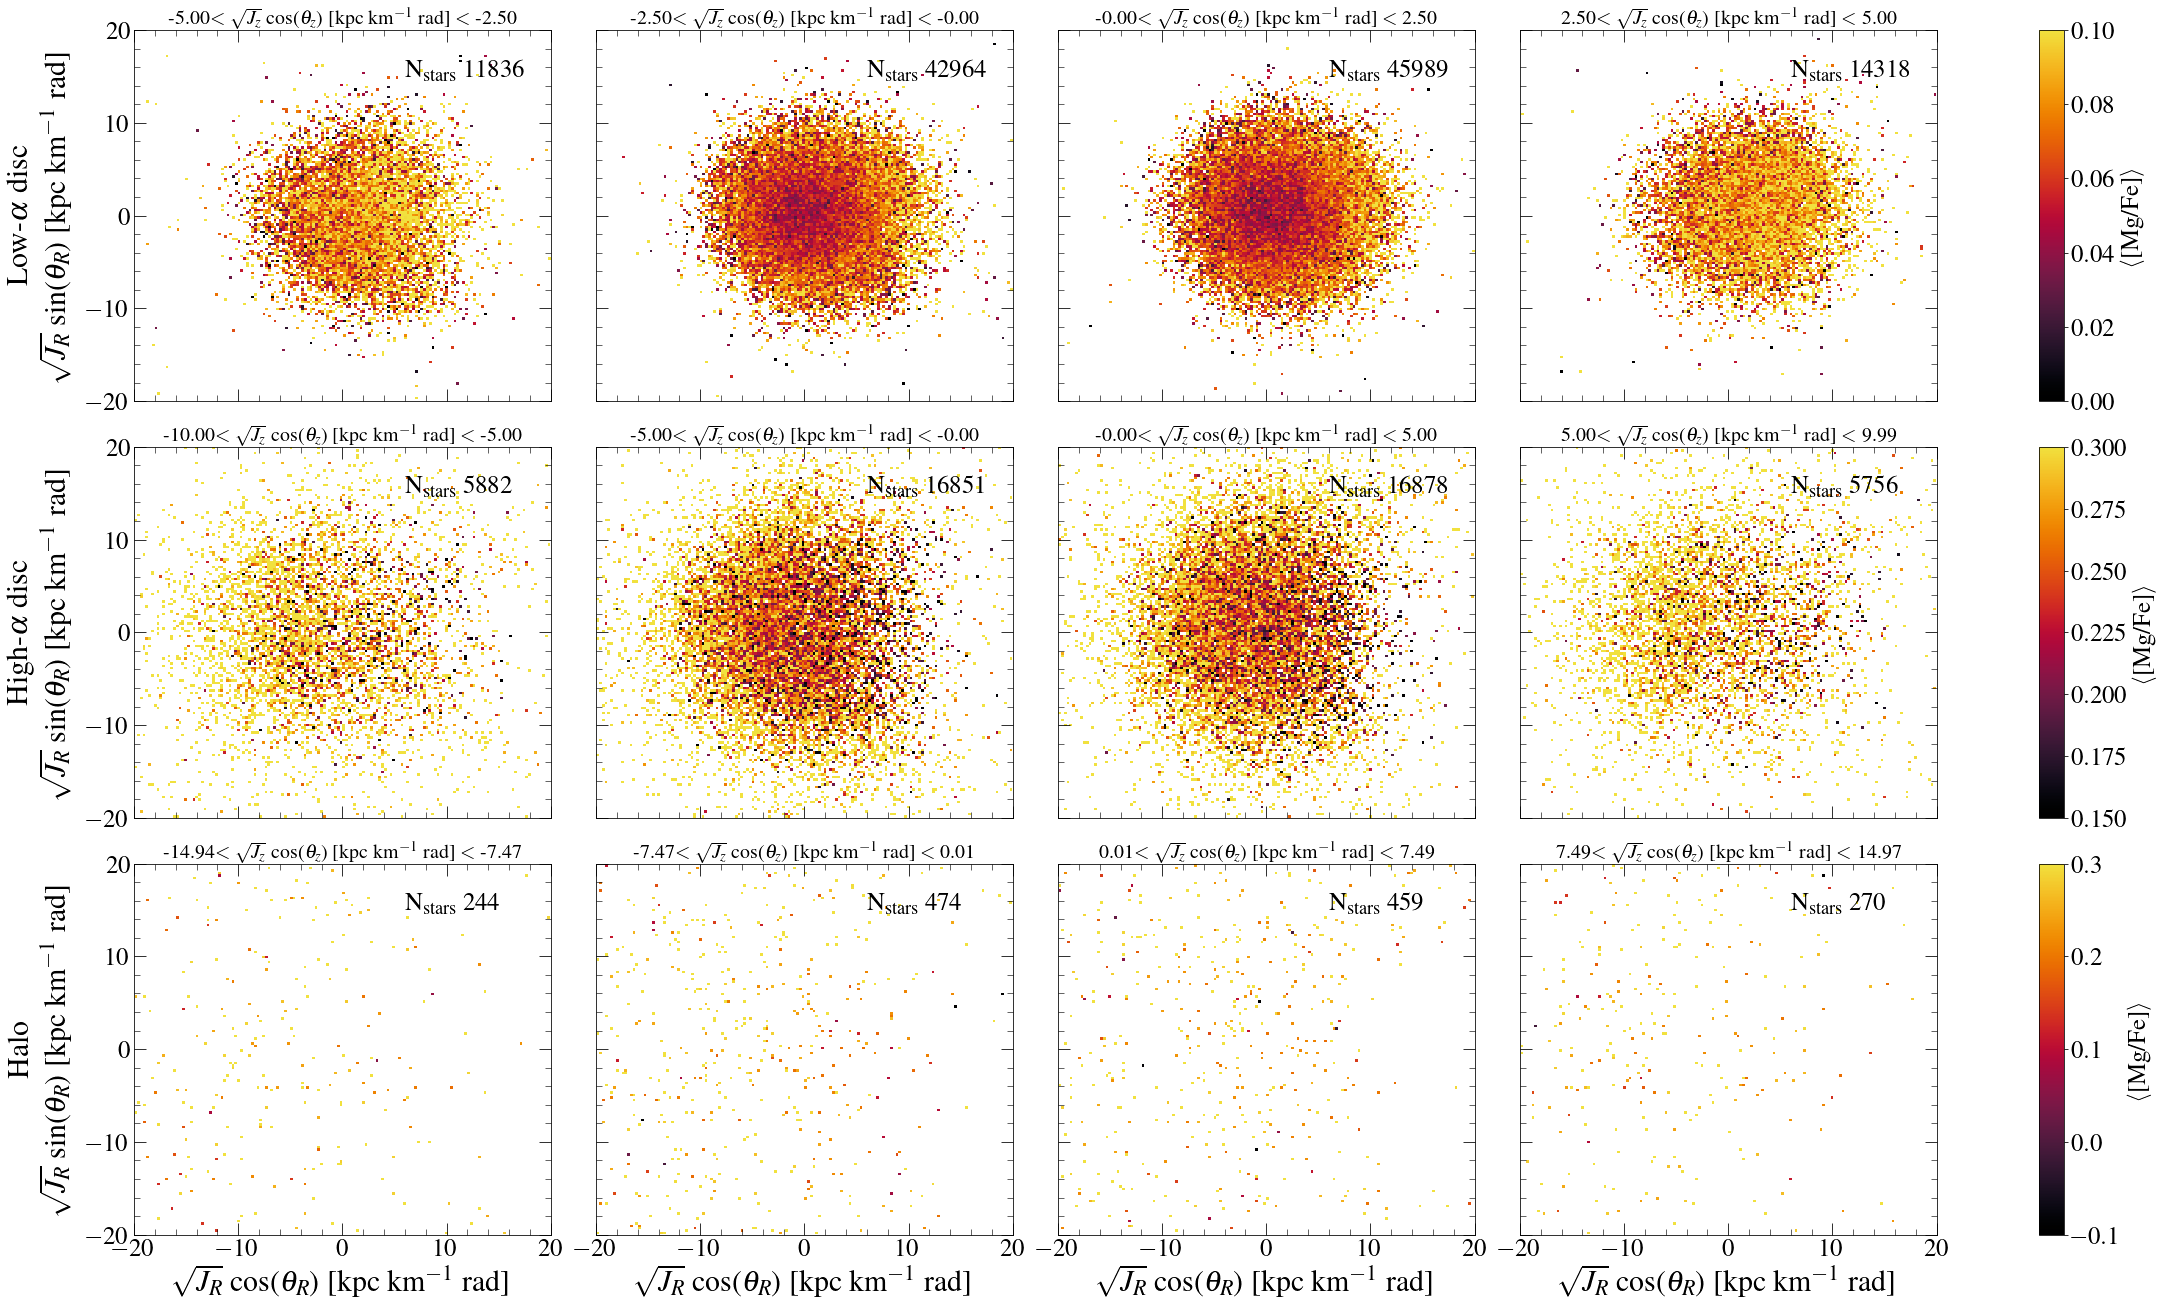

In [105]:
lowa =mask&lowa_disc_mask&(z_x>-5)&(z_x<5) &(np.abs(R_x)<20)&(np.abs(R_y)<20)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(R_x))
higha = mask&higha_disc_mask&(z_x>-10)&(z_x<10)&(np.abs(R_x)<20)&(np.abs(R_y)<20)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(R_x))
halo = mask&other_mask&(z_x>-15)&(z_x<15)&(np.abs(R_x)<20)&(np.abs(R_y)<20)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(R_x))

plot_3_3(z_x,R_x,R_y, data['MG_FE'],lowa,higha,halo,label1=r'$\sqrt{J_{z}}$ cos($\theta_{z}$) [kpc km$^{-1}$ rad]',\
         label2 = r'$\sqrt{J_{R}}$ cos($\theta_{R}$) [kpc km$^{-1}$ rad]', label3=r'$\sqrt{J_{R}}$ sin($\theta_{R}$) [kpc km$^{-1}$ rad]',\
            xlim1 = -20, xlim2 = 20, ylim1 =-20, ylim2 = 20,xnstar = 6, ynstar = 15,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/orbits-radial-vertical-3x3.pdf',dpi=200, bbox_inches = 'tight')


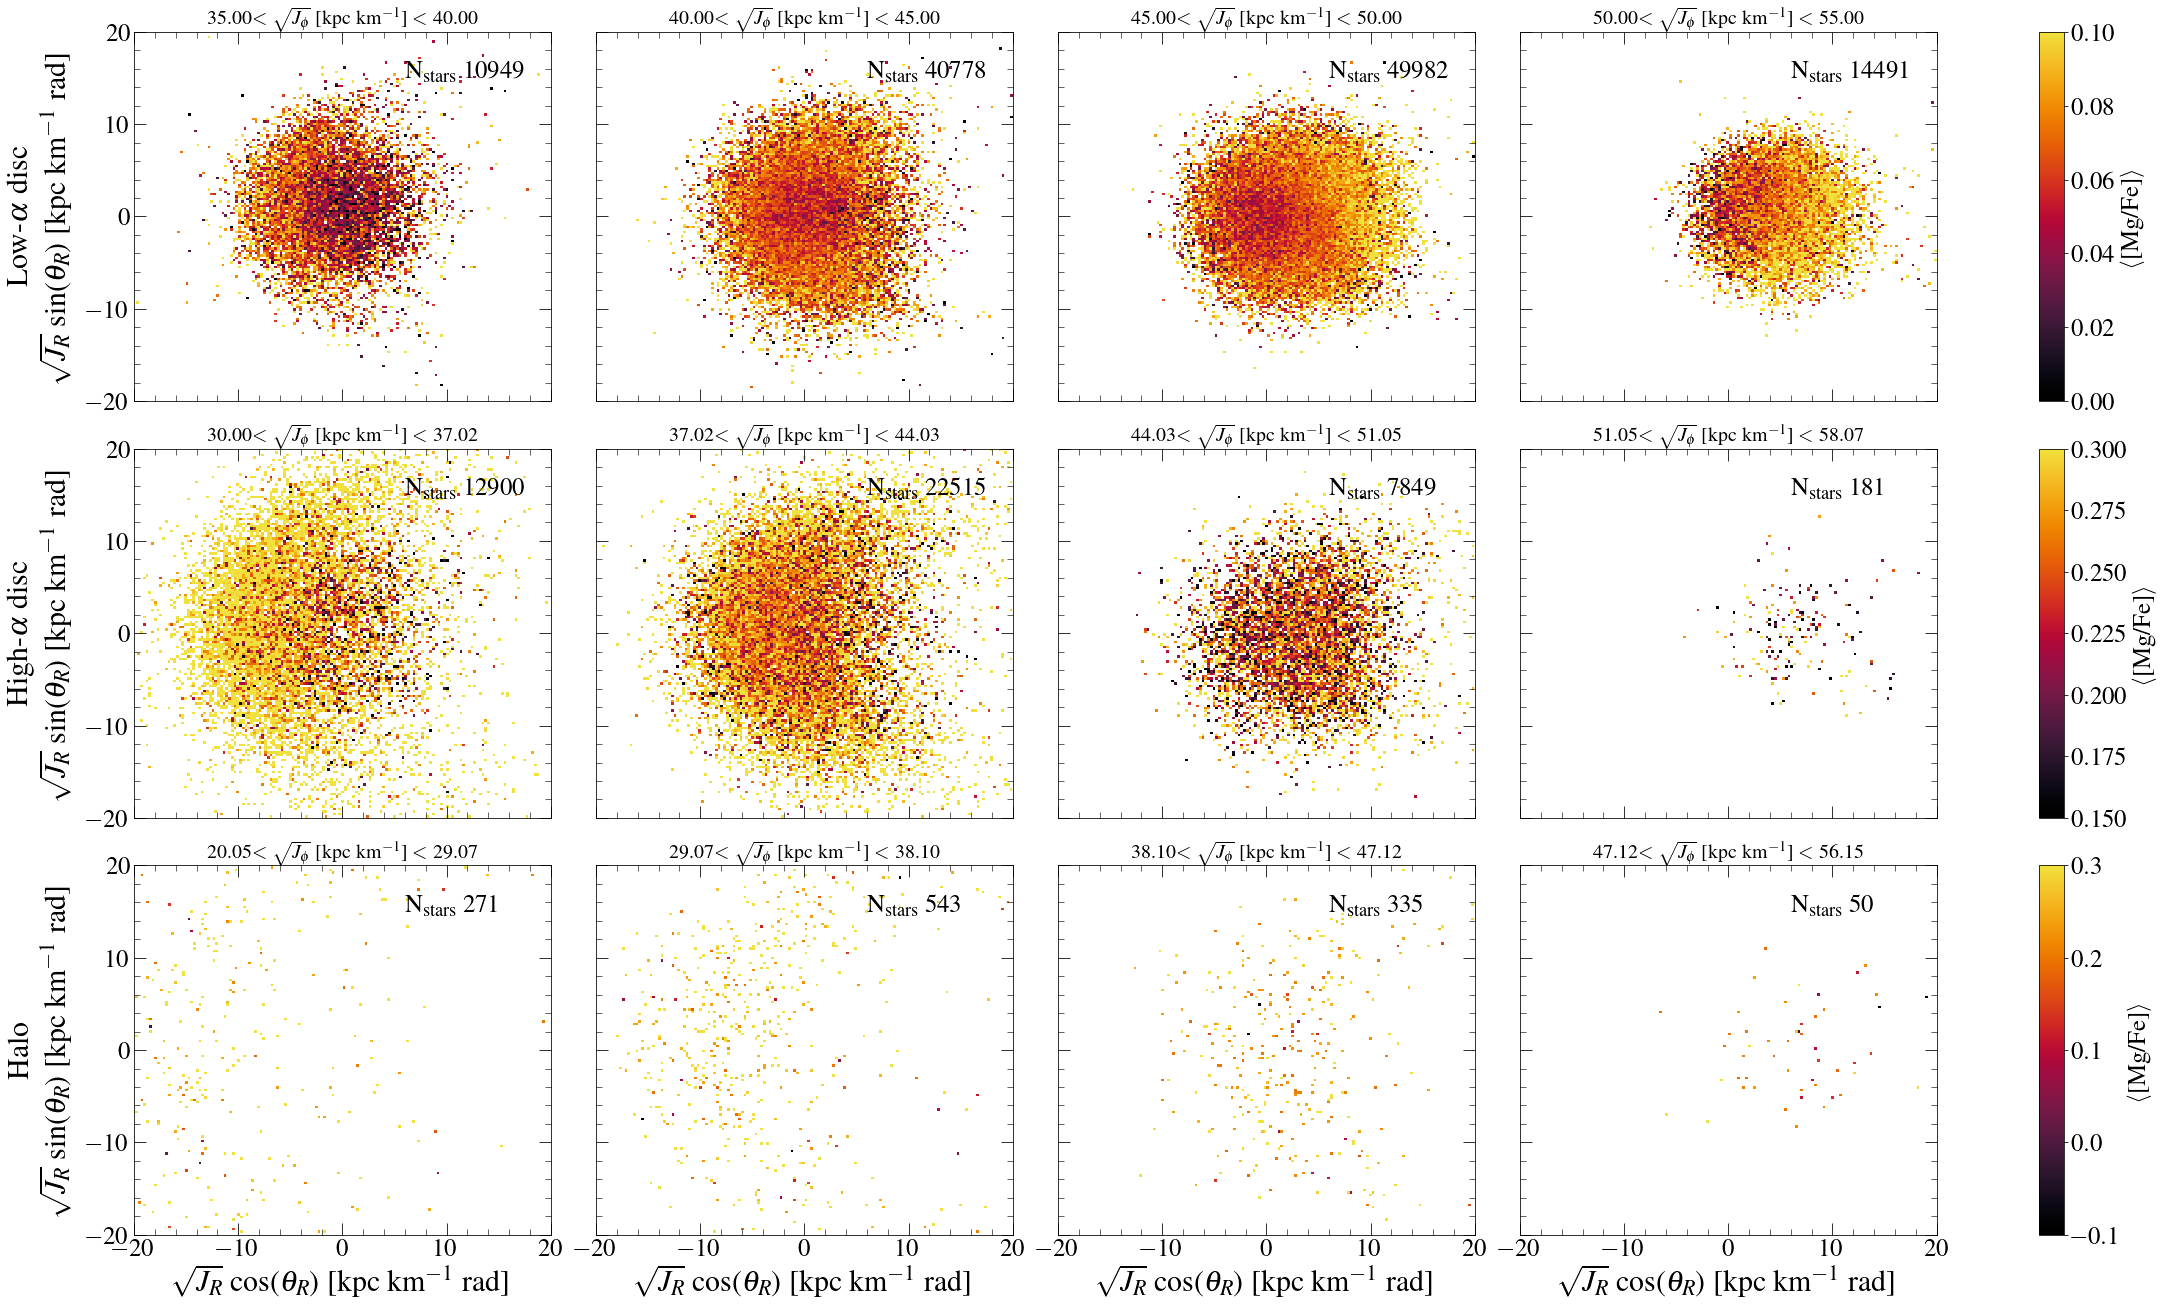

In [108]:
lowa =mask&lowa_disc_mask&(phi_diag>35)&(phi_diag<55) &(np.abs(R_x)<20)&(np.abs(R_y)<20)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(R_x))
higha = mask&higha_disc_mask&(phi_diag>30)&(phi_diag<60)&(np.abs(R_x)<20)&(np.abs(R_y)<20)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(R_x))
halo = mask&other_mask&(phi_diag>20)&(phi_diag<60)&(np.abs(R_x)<20)&(np.abs(R_y)<20)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(R_x))

plot_3_3(phi_diag,R_x,R_y, data['MG_FE'],lowa,higha,halo,label1=r'$\sqrt{J_{\phi}}$ [kpc km$^{-1}$]',\
         label2 = r'$\sqrt{J_{R}}$ cos($\theta_{R}$) [kpc km$^{-1}$ rad]', label3=r'$\sqrt{J_{R}}$ sin($\theta_{R}$) [kpc km$^{-1}$ rad]',\
            xlim1 = -20, xlim2 = 20, ylim1 =-20, ylim2 = 20,xnstar = 6, ynstar = 15,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/orbits-radial-azimuth-3x3.pdf',dpi=200, bbox_inches = 'tight')


# Azimuth

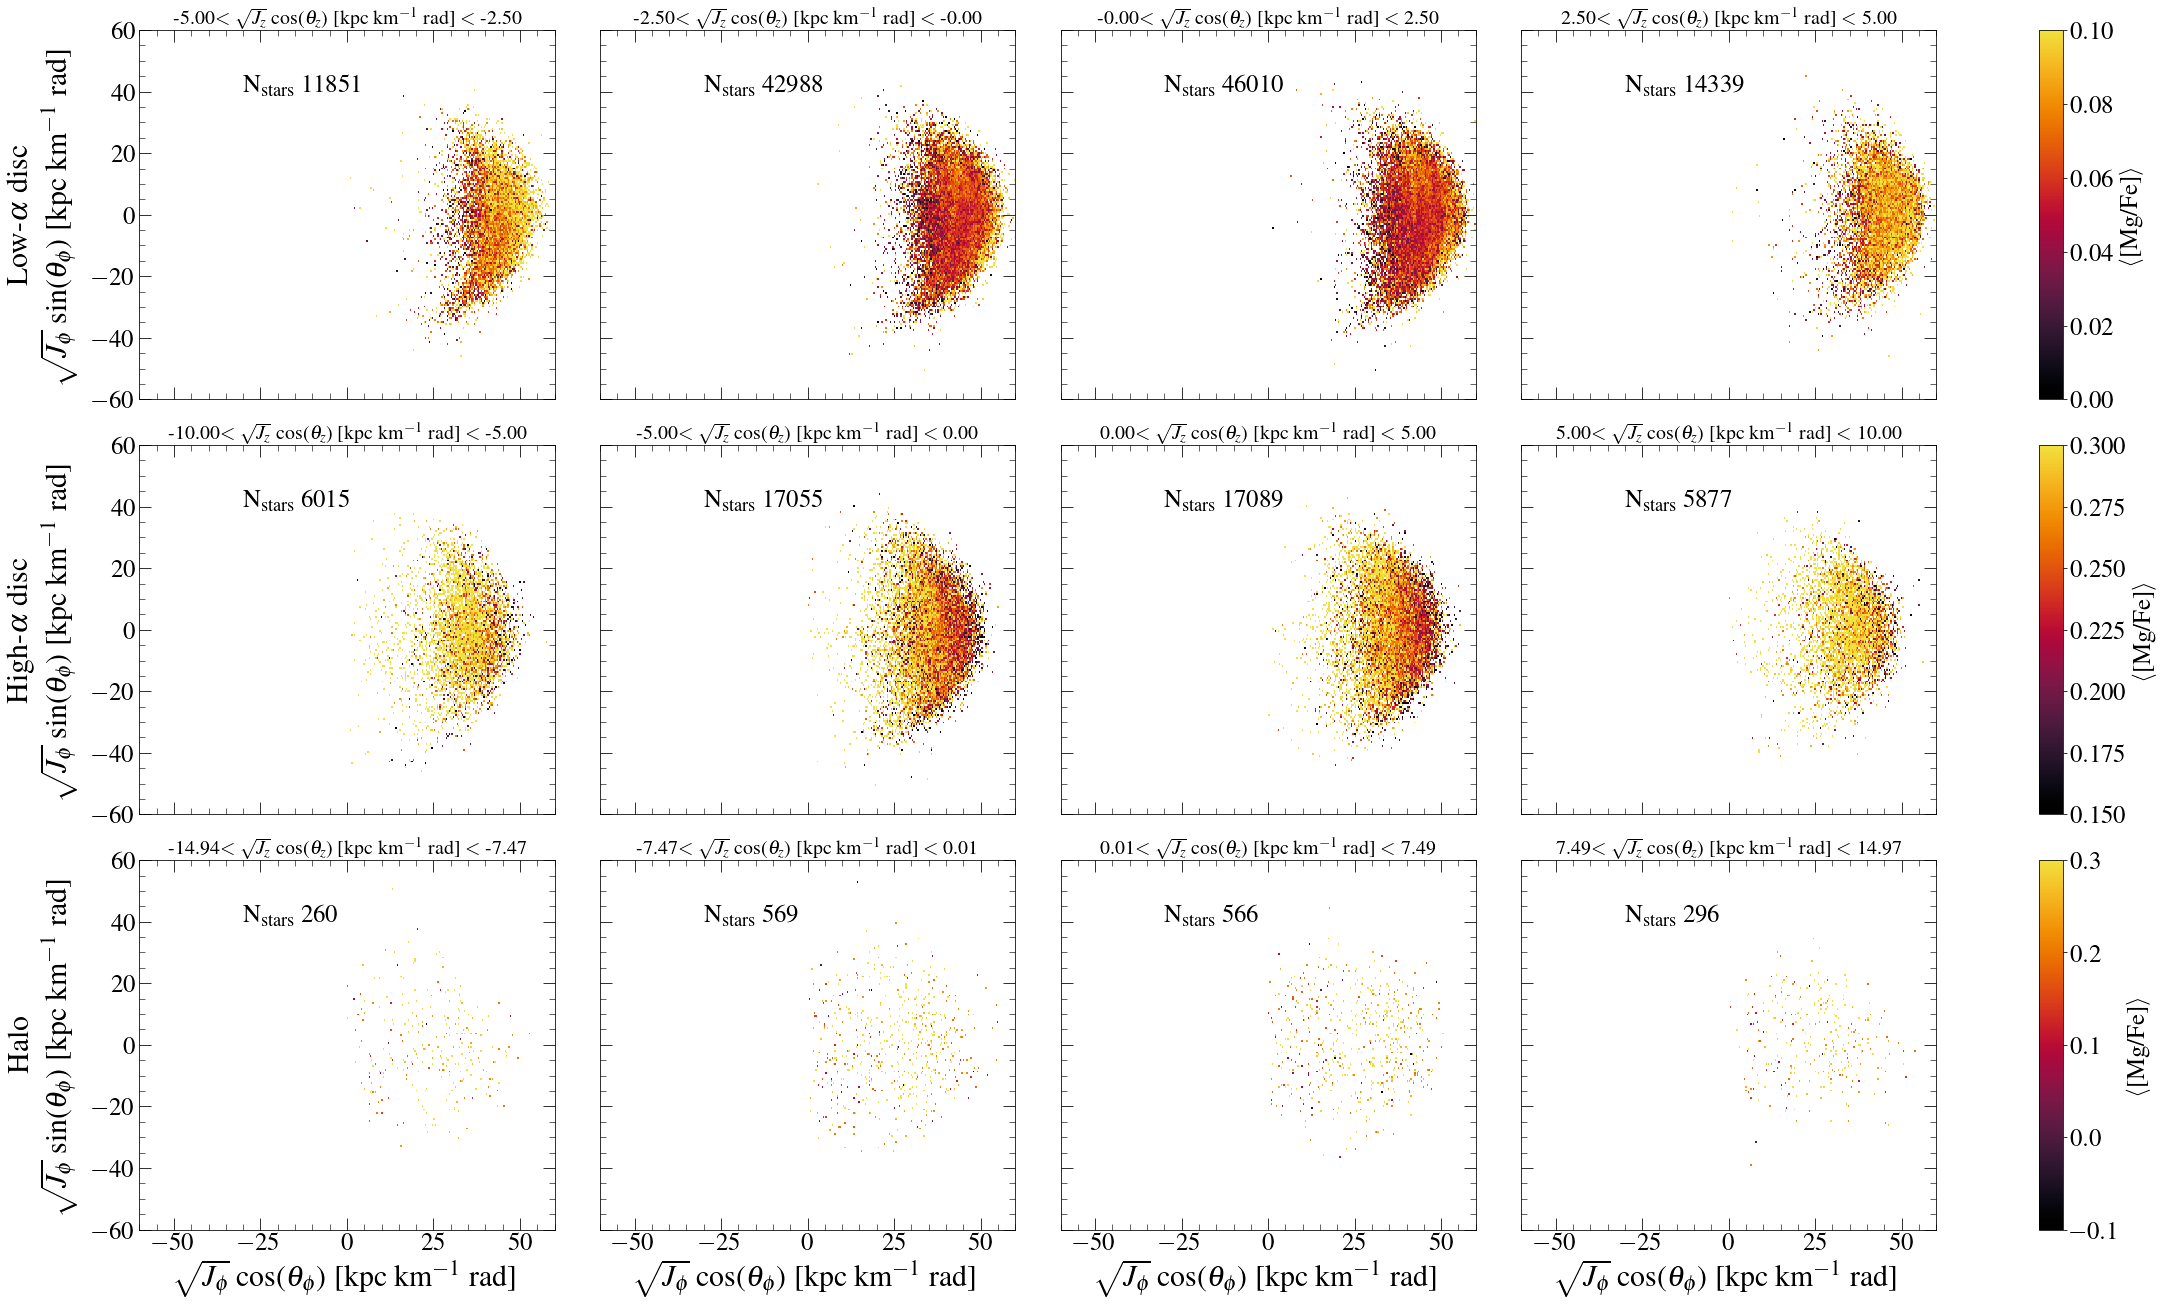

In [117]:
lowa =mask&lowa_disc_mask&(z_x>-5)&(z_x<5) &(np.abs(phi_x2)<60)&(phi_x2>0)&(np.abs(phi_y2)<60)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(R_x))
higha = mask&higha_disc_mask&(z_x>-10)&(z_x<10)&(np.abs(phi_x2)<60)&(phi_x2>0)&(np.abs(phi_y2)<60)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(R_x))
halo = mask&other_mask&(z_x>-15)&(z_x<15)&(np.abs(phi_x2)<60)&(phi_x2>0)&(np.abs(phi_y2)<60)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(R_x))

plot_3_3(z_x,phi_x2,phi_y2, data['MG_FE'],lowa,higha,halo,label1=r'$\sqrt{J_{z}}$ cos($\theta_{z}$) [kpc km$^{-1}$ rad]',\
         label2 = r'$\sqrt{J_{\phi}}$ cos($\theta_{\phi}$) [kpc km$^{-1}$ rad]', label3=r'$\sqrt{J_{\phi}}$ sin($\theta_{\phi}$) [kpc km$^{-1}$ rad]',\
            xlim1 = -60, xlim2 = 60, ylim1 =-60, ylim2 = 60,xnstar = -30, ynstar = 40,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/orbits-azimuth-vertical-3x3.pdf',dpi=200, bbox_inches = 'tight')


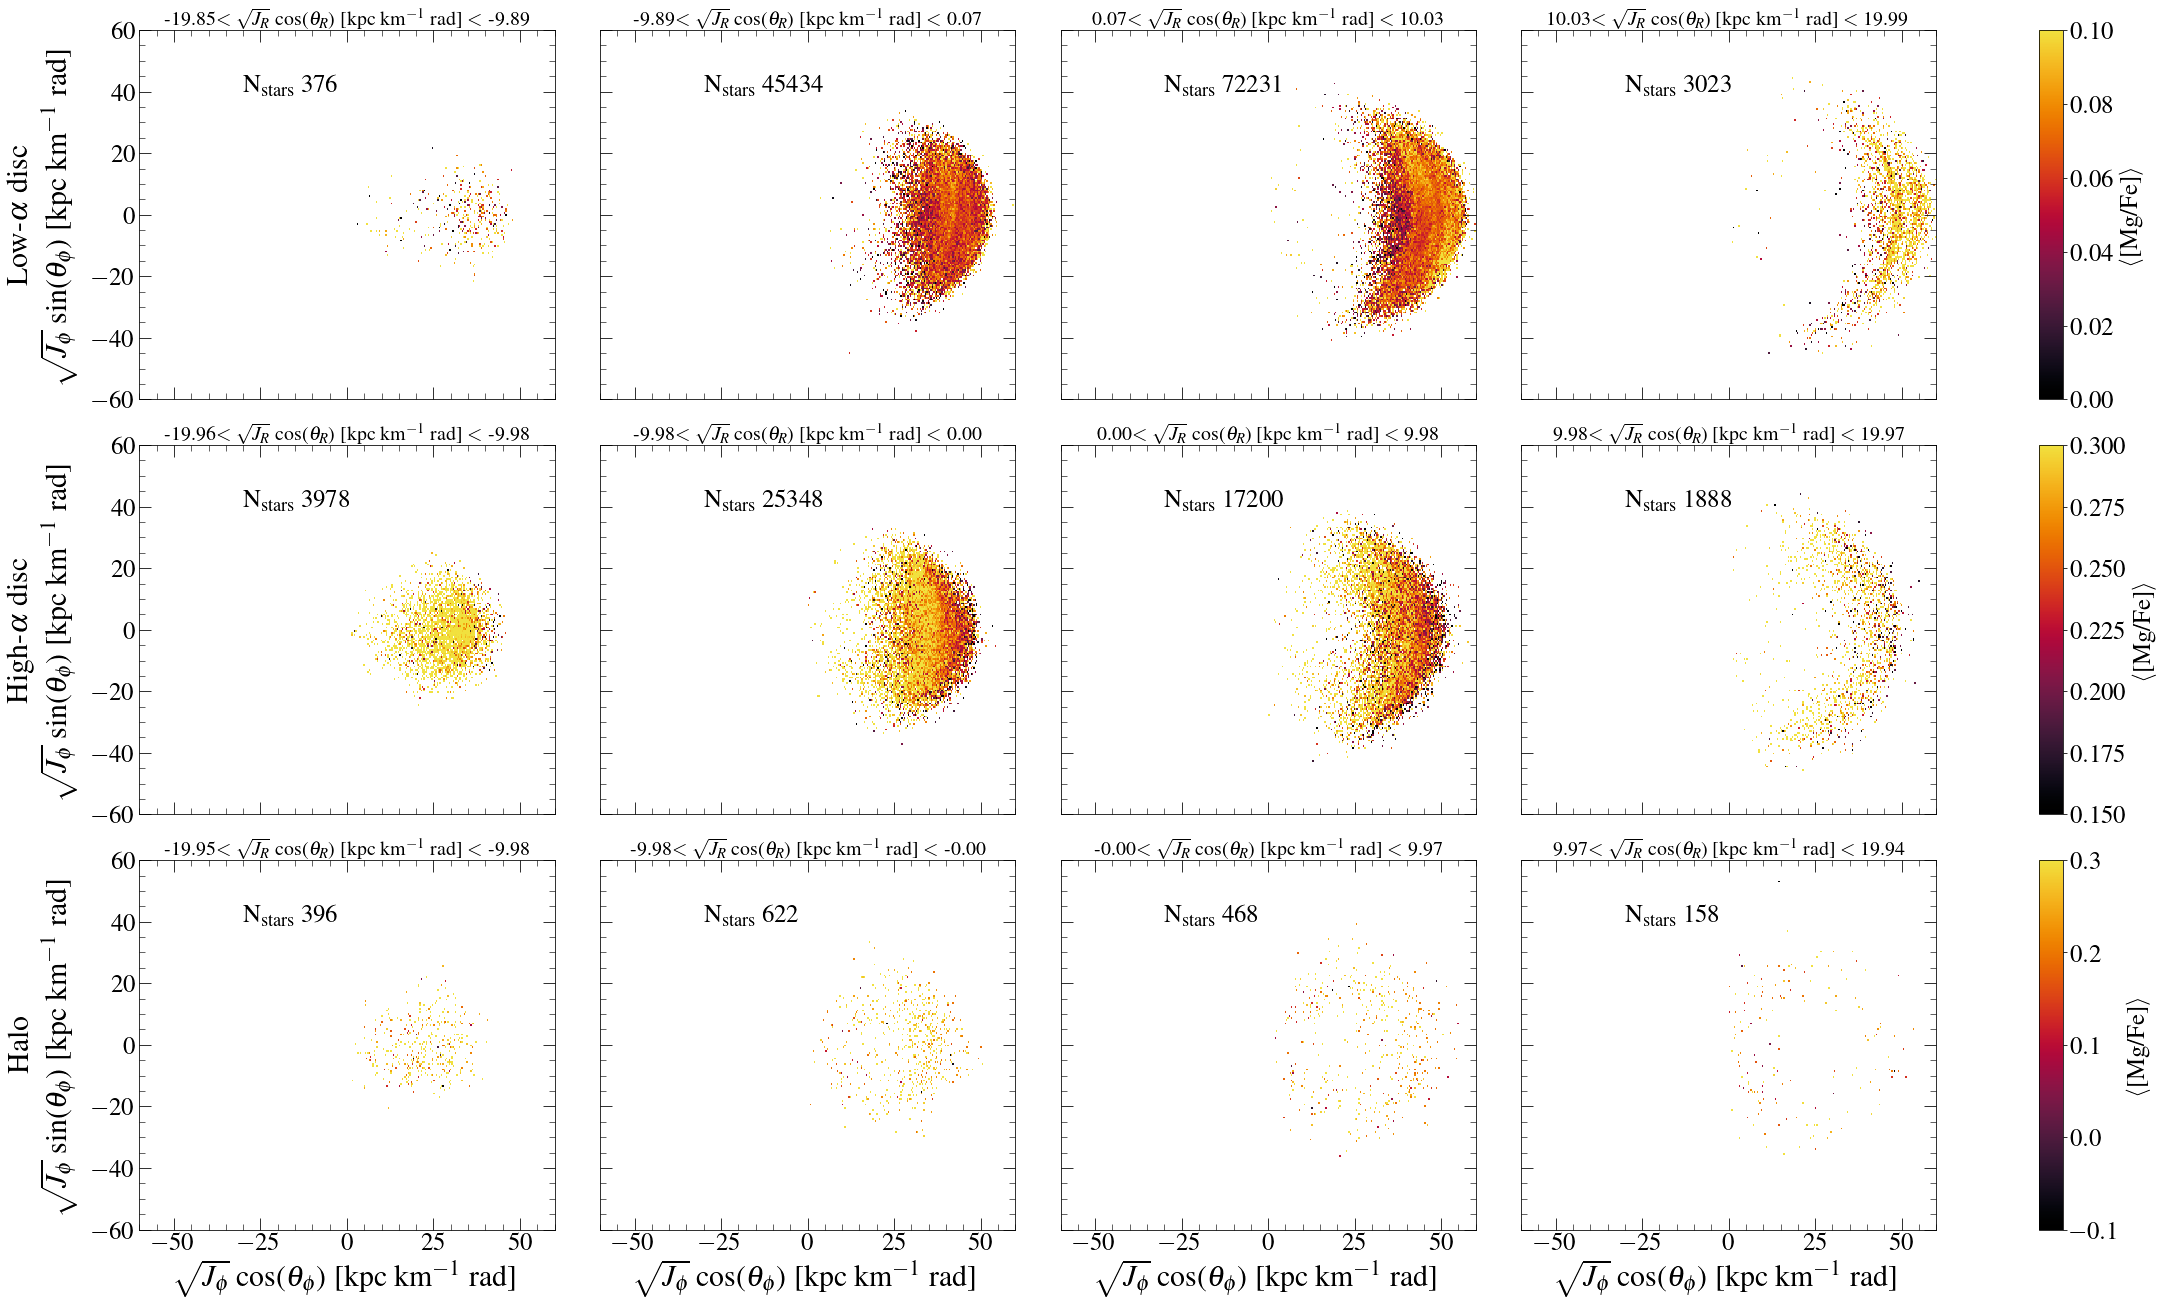

In [119]:
lowa =mask&lowa_disc_mask&(R_x>-20)&(R_x<20) &(np.abs(phi_x2)<60)&(phi_x2>0)&(np.abs(phi_y2)<60)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(R_x))
higha = mask&higha_disc_mask&(R_x>-20)&(R_x<20)&(np.abs(phi_x2)<60)&(phi_x2>0)&(np.abs(phi_y2)<60)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(R_x))
halo = mask&other_mask&(R_x>-20)&(R_x<20)&(np.abs(phi_x2)<60)&(phi_x2>0)&(np.abs(phi_y2)<60)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(R_x))

plot_3_3(R_x,phi_x2,phi_y2, data['MG_FE'],lowa,higha,halo,label1=r'$\sqrt{J_{R}}$ cos($\theta_{R}$) [kpc km$^{-1}$ rad]',\
         label2 = r'$\sqrt{J_{\phi}}$ cos($\theta_{\phi}$) [kpc km$^{-1}$ rad]', label3=r'$\sqrt{J_{\phi}}$ sin($\theta_{\phi}$) [kpc km$^{-1}$ rad]',\
            xlim1 = -60, xlim2 = 60, ylim1 =-60, ylim2 = 60,xnstar = -30, ynstar = 40,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/orbits-azimuth-radial-3x3.pdf',dpi=200, bbox_inches = 'tight')


# Now do the same with L

# L$_{x}$

In [156]:
def plot_3_3(var1, var2, var3, abun, mask1, mask2, mask3,n=5,nbins=91,xfe_label=r'$\langle$[Mg/Fe]$\rangle$',\
            label1=r'$\Delta R$ [kpc]', label2 = r'$R_{g}$ [kpc]', label3=r'$z_{\mathrm{max}}$ [kpc]',\
            xlim1 = 0, xlim2 = 15, ylim1 =0, ylim2 = 8,xnstar = 9, ynstar = 7):
    """
    Take three variables (say J) and 3 samples (say high-/low-alpha discs and halo) and plot two variables conditioned
    on the other. 
    """
    
    fig, all_axes = plt.subplots(3, 4, constrained_layout=True, figsize=(30, 18), sharex=True, sharey=True, rasterized=True)
    
    # for mask1
    xs = np.around(np.linspace(np.min(var1[mask1]),np.max(var1[mask1]),n),decimals=2)
    # for mask2
    xs2 = np.around(np.linspace(np.min(var1[mask2]),np.max(var1[mask2]),n),decimals=2)
    # for mask3
    xs3 = np.around(np.linspace(np.min(var1[mask3]),np.max(var1[mask3]),n),decimals=2)   
    
    # set up an array of the x grids to loop over
    exis = np.array((xs,xs2,xs3))
    
    for indx, i in enumerate(exis):
        axis = all_axes[indx]
        for indx2, k in enumerate(i[:-1]):
                # create a mask for every loop
                if k<i[-1] and indx==0:
                        mask_loop = (var1[mask1]>k)&(var1[mask1]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask1]),np.max(var2[mask1]),nbins)
                        biny = np.linspace(np.min(var3[mask1]),np.max(var3[mask1]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask1][mask_loop],var3[mask1][mask_loop], abun[mask1][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.0,vmax=0.1)         
                        ax.set_xlim(xlim1,xlim2)
                        ax.set_ylim(ylim1,ylim2)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(xnstar,ynstar,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask1][mask_loop])),fontsize=25)
                        ax.set_title(r'' +str('%5.0f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.0f' %i[indx2+1]),fontsize=30)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()
                        
                if k<i[-1] and indx==1:
                        mask_loop = (var1[mask2]>k)&(var1[mask2]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask2]),np.max(var2[mask2]),nbins)
                        biny = np.linspace(np.min(var3[mask2]),np.max(var3[mask2]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask2][mask_loop],var3[mask2][mask_loop], abun[mask2][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=0.15,vmax=0.3)         
                        ax.set_xlim(xlim1,xlim2)
                        ax.set_ylim(ylim1,ylim2)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(xnstar,ynstar,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask2][mask_loop])),fontsize=25)
                        ax.set_title(r'' +str('%5.0f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.0f' %i[indx2+1]),fontsize=30)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()

                if k<i[-1] and indx==2:
                        mask_loop = (var1[mask3]>k)&(var1[mask3]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask3]),np.max(var2[mask3]),nbins)
                        biny = np.linspace(np.min(var3[mask3]),np.max(var3[mask3]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask3][mask_loop],var3[mask3][mask_loop], abun[mask3][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.1,vmax=0.3)         
                        ax.set_xlim(xlim1,xlim2)
                        ax.set_ylim(ylim1,ylim2)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(xnstar,ynstar,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask3][mask_loop])),fontsize=25)
                        ax.set_title(r'' +str('%5.0f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.0f' %i[indx2+1]),fontsize=30)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()
                else:
                    pass
        cbar = fig.colorbar(color, ax = axis, aspect=15)
        cbar.set_label(label=xfe_label,fontsize=25)
        cbar.ax.tick_params(labelsize=25)

    for ax in all_axes[-1]:
        ax.set_xlabel(label2,fontsize=40)

    all_axes[0,0].set_ylabel(r'Low-$\alpha$ disc' +' \n '+str(label3),fontsize=40,labelpad=15)
    all_axes[1,0].set_ylabel(r'High-$\alpha$ disc' +' \n '+str(label3),fontsize=40,labelpad=15)
    all_axes[2,0].set_ylabel(r'Halo' +' \n '+str(label3),fontsize=40,labelpad=15)
  

In [144]:
# Lx = data['L'][:,0]
# Ly = data['L'][:,1]
# Lz = data['L'][:,2]*-1

Lx = (data['vxyz'][:,1]*data['xyz'][:,2]-data['vxyz'][:,2]*data['xyz'][:,1])
Ly = (data['vxyz'][:,2]*data['xyz'][:,0]-data['vxyz'][:,0]*data['xyz'][:,2])
Lz = (data['vxyz'][:,0]*data['xyz'][:,1]-data['vxyz'][:,1]*data['xyz'][:,0])


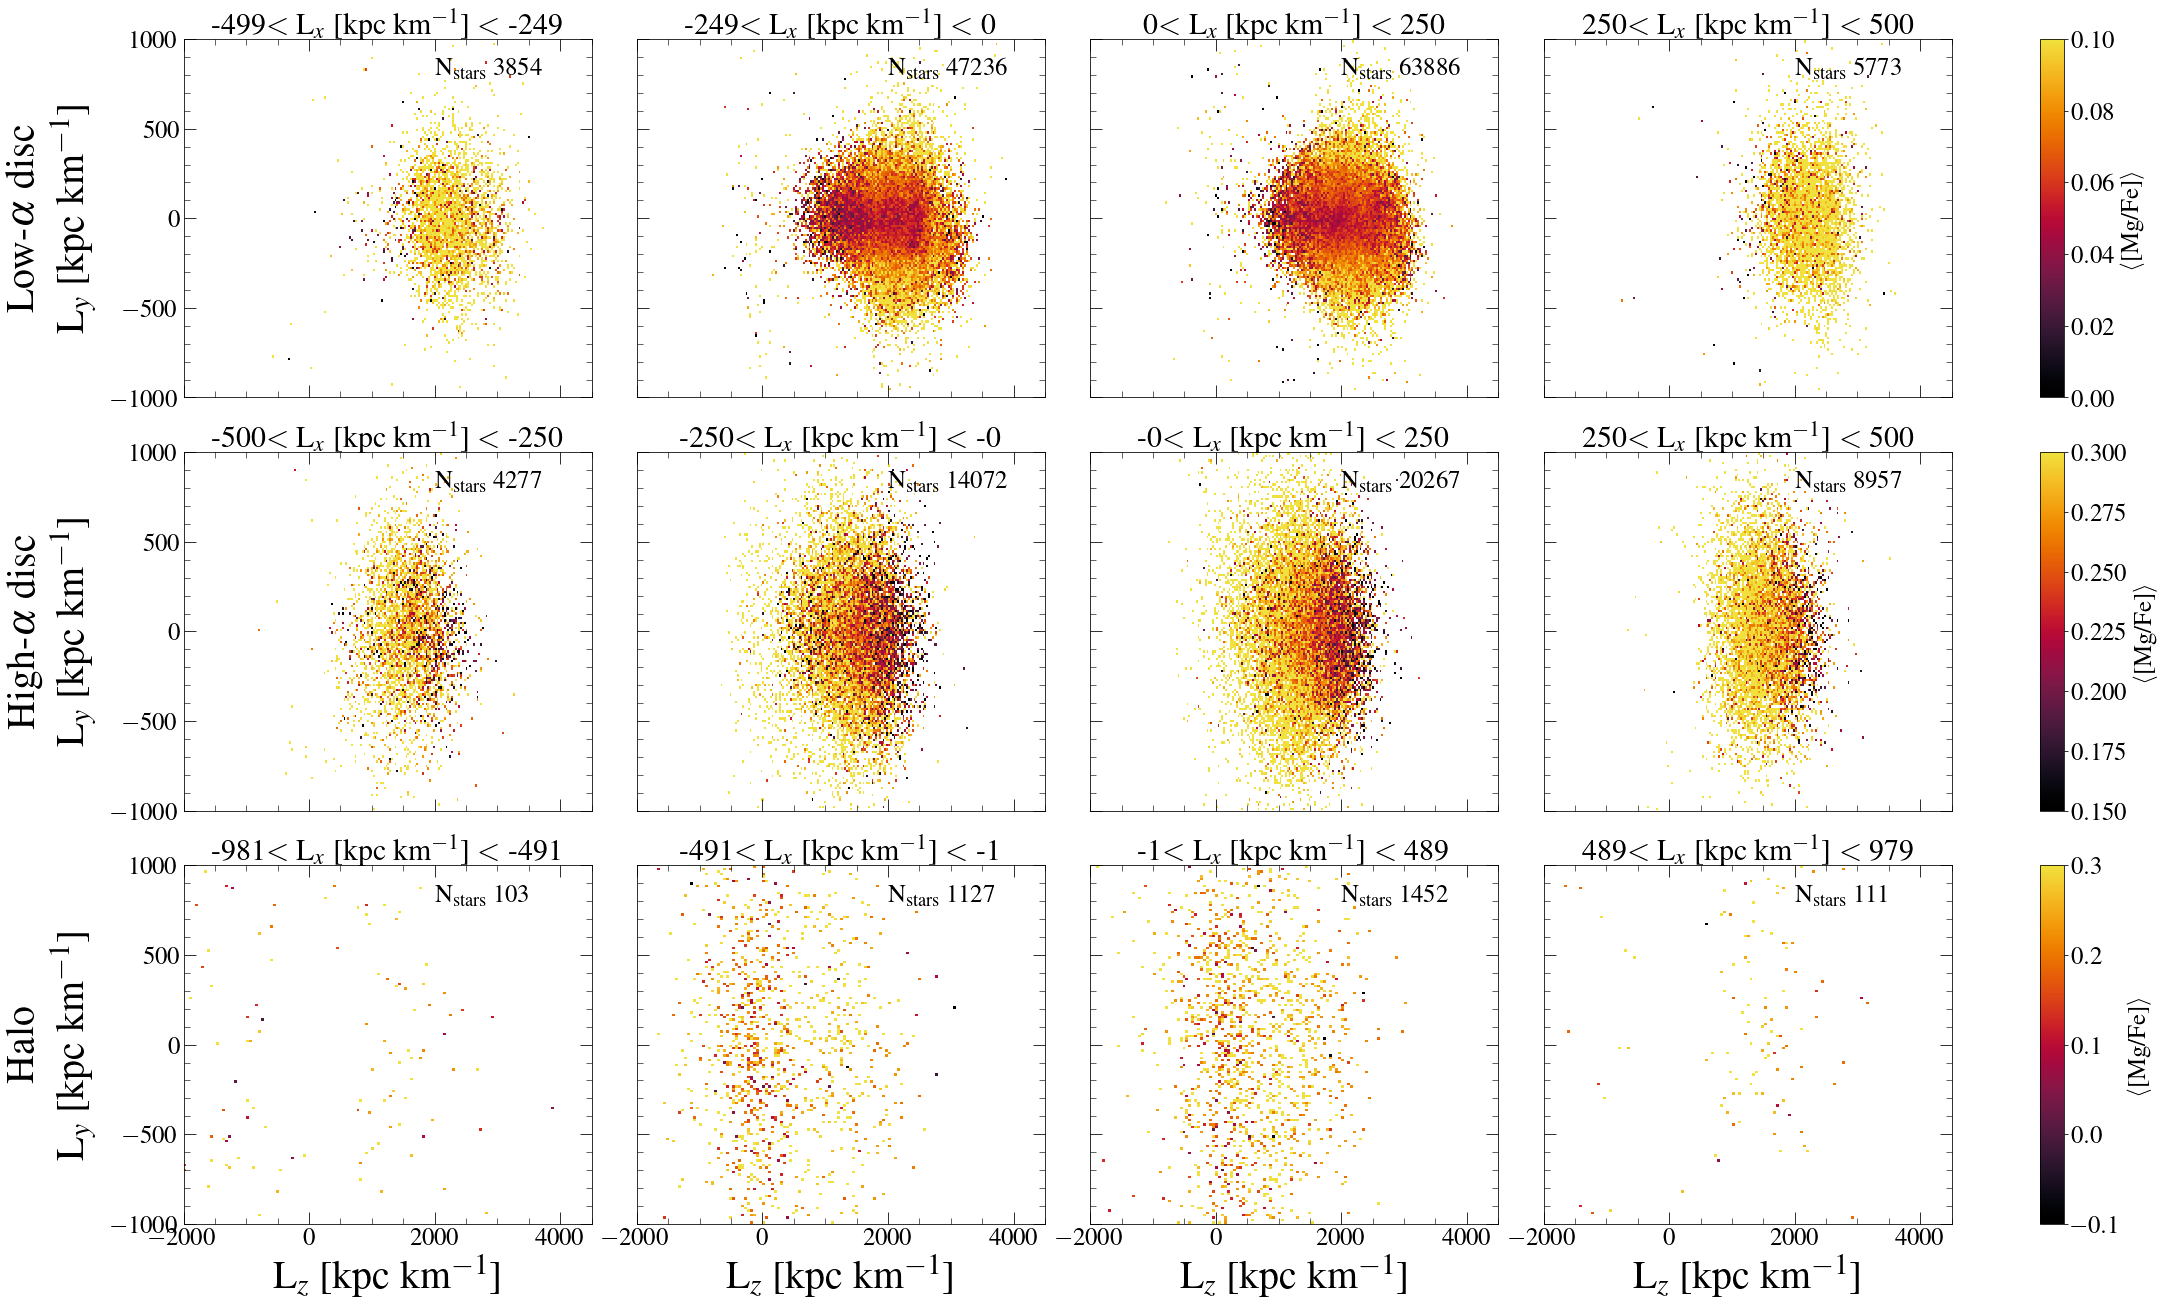

In [166]:
lowa =mask&lowa_disc_mask&(Lx>-500)&(Lx<500) &(np.abs(Ly)<1000)&(np.abs(Lz)<4e3)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(Lx))
higha = mask&higha_disc_mask&(Lx>-500)&(Lx<500) &(np.abs(Ly)<1000)&(np.abs(Lz)<4e3)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(Lx))
halo = mask&other_mask&(Lx>-1000)&(Lx<1000) &(np.abs(Ly)<1000)&(np.abs(Lz)<4e3)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(Lx))

plot_3_3(Lx,Lz,Ly, data['MG_FE'],lowa,higha,halo,label1=r'L$_{x}$ [kpc km$^{-1}$]',\
         label2 = r'L$_{z}$ [kpc km$^{-1}$]', label3=r'L$_{y}$ [kpc km$^{-1}$]',\
            xlim1 = -2000, xlim2 = 4500, ylim1 =-1000, ylim2 = 1000,xnstar = 2000, ynstar = 800,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/angularmomentum-Lx-3x3.pdf',dpi=200, bbox_inches = 'tight')


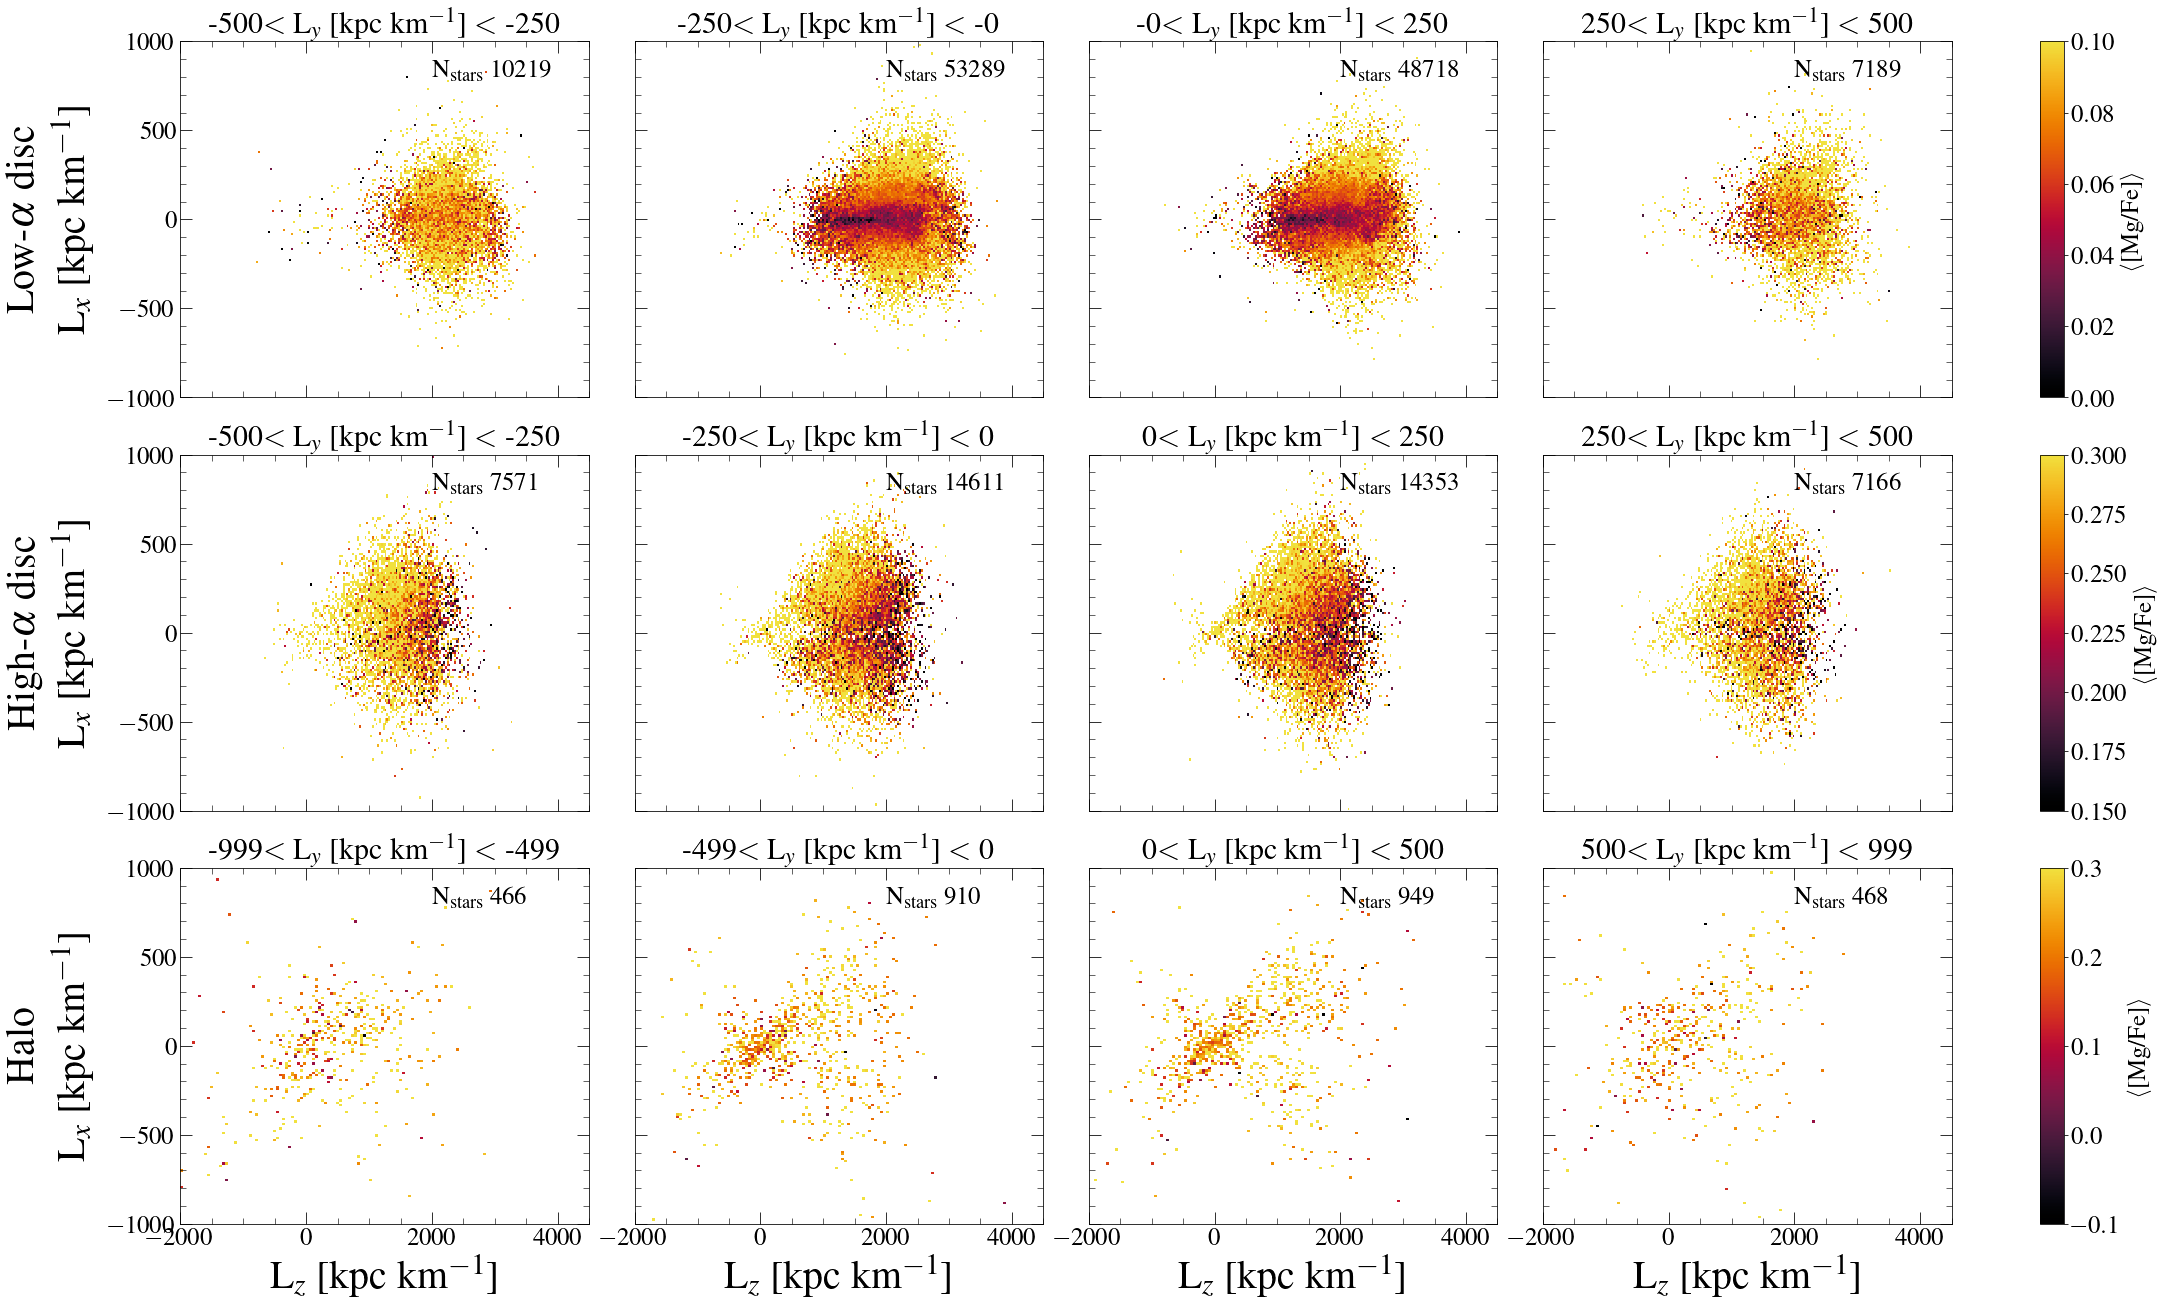

In [167]:
lowa =mask&lowa_disc_mask&(Lx>-1000)&(Lx<1000) &(np.abs(Ly)<500)&(np.abs(Lz)<4e3)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(Lx))
higha = mask&higha_disc_mask&(Lx>-1000)&(Lx<1000) &(np.abs(Ly)<500)&(np.abs(Lz)<4e3)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(Lx))
halo = mask&other_mask&(Lx>-1000)&(Lx<1000) &(np.abs(Ly)<1000)&(np.abs(Lz)<4e3)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(Lx))

plot_3_3(Ly,Lz,Lx, data['MG_FE'],lowa,higha,halo,label1=r'L$_{y}$ [kpc km$^{-1}$]',\
         label2 = r'L$_{z}$ [kpc km$^{-1}$]', label3=r'L$_{x}$ [kpc km$^{-1}$]',\
            xlim1 = -2000, xlim2 = 4500, ylim1 =-1000, ylim2 = 1000,xnstar = 2000, ynstar = 800,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/angularmomentum-Ly-3x3.pdf',dpi=200, bbox_inches = 'tight')


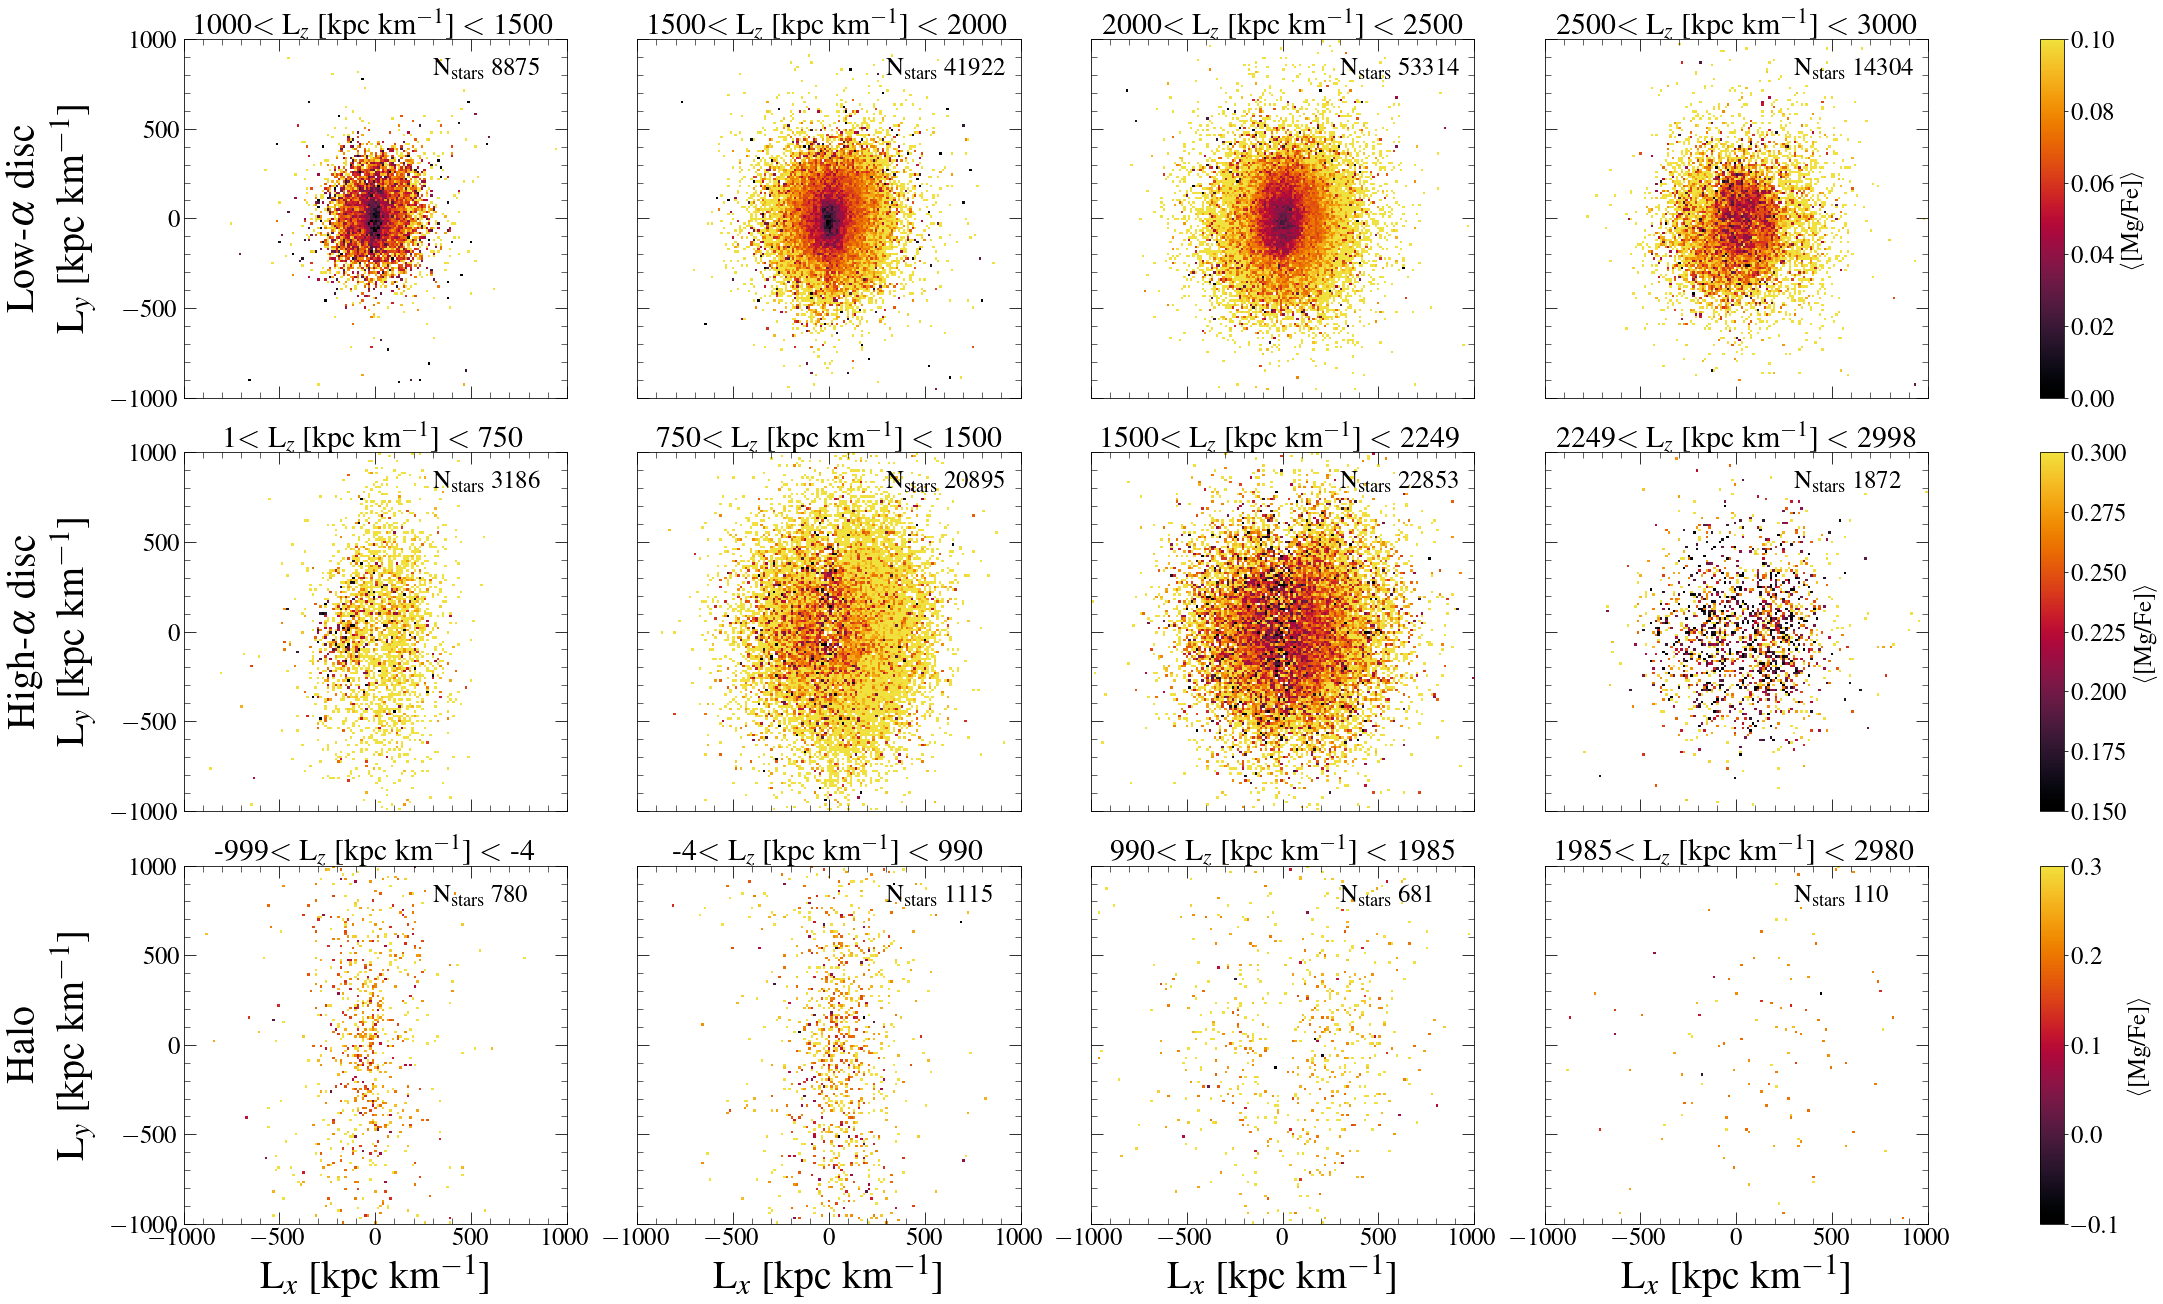

In [169]:
lowa =mask&lowa_disc_mask&(Lx>-1000)&(Lx<1000) &(np.abs(Ly)<1000)&(Lz<3e3)&(Lz>1000)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(Lx))
higha = mask&higha_disc_mask&(Lx>-1000)&(Lx<1000) &(np.abs(Ly)<1000)&(Lz<3e3)&(Lz>0)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(Lx))
halo = mask&other_mask&(Lx>-1000)&(Lx<1000) &(np.abs(Ly)<1000)&(Lz<3e3)&(Lz>-1e3)&(data['MG_FE']>-10)\
 &(~np.isnan(data['MG_FE']))&(~np.isnan(Lx))

plot_3_3(Lz,Lx,Ly, data['MG_FE'],lowa,higha,halo,label1=r'L$_{z}$ [kpc km$^{-1}$]',\
         label2 = r'L$_{x}$ [kpc km$^{-1}$]', label3=r'L$_{y}$ [kpc km$^{-1}$]',\
            xlim1 = -1000, xlim2 = 1000, ylim1 =-1000, ylim2 = 1000,xnstar = 300, ynstar = 800,nbins=151)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/angularmomentum-Lz-3x3.pdf',dpi=200, bbox_inches = 'tight')


In [176]:
import astropy.units as u
x = data['xyz'][:,0]
y = data['xyz'][:,1]
z = data['xyz'][:,2]
vz = data['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(Rgal-8.275)
Rg = -(data['L'][:,2]/vcirc)
phi = np.arctan(data['xyz'][:,1]/data['xyz'][:,0])

# first flip Lz and Jz as they are computed in right hand rule
jphi = data['actions'][:,1]*-1
jr = data['actions'][:,0]
jz = data['actions'][:,2]
zmax = data['z_max']
deltaR = Rgal-Rg


(-0.15, 0.2)

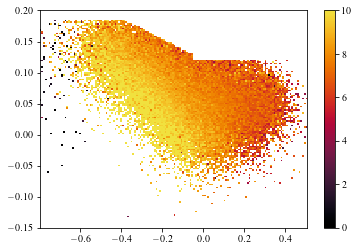

In [185]:
omask = (Rg>0)&(Rg<15)&(zmax<8)&(zmax>0)&(deltaR<15)&(deltaR>0)&mask&lowa_disc_mask

binx = np.linspace(np.min(data['FE_H'][omask]),np.max(data['FE_H'][omask]),nbins)
biny = np.linspace(np.min(data['MG_FE'][omask]),np.max(data['MG_FE'][omask]),nbins)
hist = stats.binned_statistic_2d(data['FE_H'][omask],data['MG_FE'][omask], Rg[omask], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.0,vmax=10)    
plt.colorbar()
plt.ylim(-0.15,0.2)

(-0.15, 0.2)

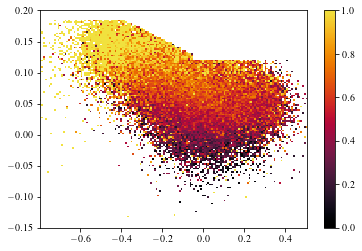

In [189]:
omask = (Rg>0)&(Rg<15)&(zmax<8)&(zmax>0)&(deltaR<15)&(deltaR>0)&mask&lowa_disc_mask

binx = np.linspace(np.min(data['FE_H'][omask]),np.max(data['FE_H'][omask]),nbins)
biny = np.linspace(np.min(data['MG_FE'][omask]),np.max(data['MG_FE'][omask]),nbins)
hist = stats.binned_statistic_2d(data['FE_H'][omask],data['MG_FE'][omask], zmax[omask], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.0,vmax=1)    
plt.colorbar()
plt.ylim(-0.15,0.2)